In [1]:

# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# For evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import os
import joblib  # Use joblib to save scalers

# Detect if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seed for reproducibility
torch.manual_seed(42)


Using device: cpu


In [2]:
pip install nbformat


Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install plotly 


Note: you may need to restart the kernel to use updated packages.


In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly 

# Function to download data for a single ticker
def download_ticker_data(ticker, start_date, end_date, save_csv=False):
    """
    Downloads historical stock data for a given ticker symbol between specified dates.

    Args:
        ticker (str): Stock ticker symbol (e.g., 'AAPL' for Apple Inc.).
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.
        save_csv (bool): If True, saves the data to a CSV file named '{ticker}_data.csv'.

    Returns:
        pd.DataFrame: DataFrame containing the historical stock data.
    """
    df = yf.download(ticker, start=start_date, end=end_date)
    if save_csv:
        df.to_csv(f'{ticker}_data.csv')
    return df

# Define the list of tickers and date range
tickers = ['AAPL', 'GOOG', 'META', 'MSFT', 'AMZN']
start_date = '2019-01-01'
end_date = '2024-10-08'

# Dictionary to store data for each ticker
ticker_data = {}

# Download data for each ticker
for ticker in tickers:
    print(f"Downloading data for {ticker}...")
    df = download_ticker_data(ticker, start_date, end_date)
    ticker_data[ticker] = df

def add_technical_indicators(df):
    """
    Adds technical indicators to the stock data DataFrame.

    Indicators added:
        - Simple Moving Averages (SMA_20, SMA_50)
        - Exponential Moving Average (EMA_20)
        - Relative Strength Index (RSI)
        - Moving averages of Volume, High, Low, and Open prices

    Args:
        df (pd.DataFrame): DataFrame containing stock data with 'Adj Close', 'Volume', 'High', 'Low', 'Open' columns.

    Returns:
        pd.DataFrame: DataFrame with additional technical indicators.
    """
    df = df.copy()

    # Simple Moving Averages
    df['SMA_20'] = df['Adj Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Adj Close'].rolling(window=50).mean()

    # Exponential Moving Average
    df['EMA_20'] = df['Adj Close'].ewm(span=20, adjust=False).mean()

    # Relative Strength Index (RSI)
    delta = df['Adj Close'].diff(1)
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    time_period = 14
    avg_gain = up.rolling(window=time_period, min_periods=time_period).mean()
    avg_loss = down.rolling(window=time_period, min_periods=time_period).mean()
    rs = avg_gain / avg_loss
    rsi = 100.0 - (100.0 / (1.0 + rs))
    df['RSI'] = rsi

    # Additional Moving Averages
    df['Volume_MA_20'] = df['Volume'].rolling(window=20).mean()
    df['High_MA_20'] = df['High'].rolling(window=20).mean()
    df['Low_MA_20'] = df['Low'].rolling(window=20).mean()
    df['Open_MA_20'] = df['Open'].rolling(window=20).mean()

    return df

# Apply technical indicators to each ticker
for ticker in tickers:
    print(f"Adding technical indicators to {ticker} data...")
    df = ticker_data[ticker]
    df = add_technical_indicators(df)
    df.dropna(inplace=True)  # Drop rows with NaN values resulting from indicator calculations
    ticker_data[ticker] = df






[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed

Adding technical indicators to AAPL data...
Adding technical indicators to GOOG data...
Adding technical indicators to META data...
Adding technical indicators to MSFT data...
Adding technical indicators to AMZN data...


In [5]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Generate Interactive Line Plots with Moving Averages for each Ticker
for ticker in tickers:
    df = ticker_data[ticker]

    fig = make_subplots(rows=1, cols=1)

    # Adjusted Close Price
    fig.add_trace(go.Scatter(x=df.index, y=df['Adj Close'],
                             mode='lines',
                             name='Adj Close',
                             line=dict(color='blue')))

    # 20-Day SMA
    fig.add_trace(go.Scatter(x=df.index, y=df['SMA_20'],
                             mode='lines',
                             name='20-Day SMA',
                             line=dict(color='red', dash='dash')))

    # 50-Day SMA
    fig.add_trace(go.Scatter(x=df.index, y=df['SMA_50'],
                             mode='lines',
                             name='50-Day SMA',
                             line=dict(color='green', dash='dash')))

    fig.update_layout(title=f'Interactive Adjusted Close Price and Moving Averages for {ticker}',
                      xaxis_title='Date',
                      yaxis_title='Price ($)',
                      hovermode='x unified')

    fig.show()

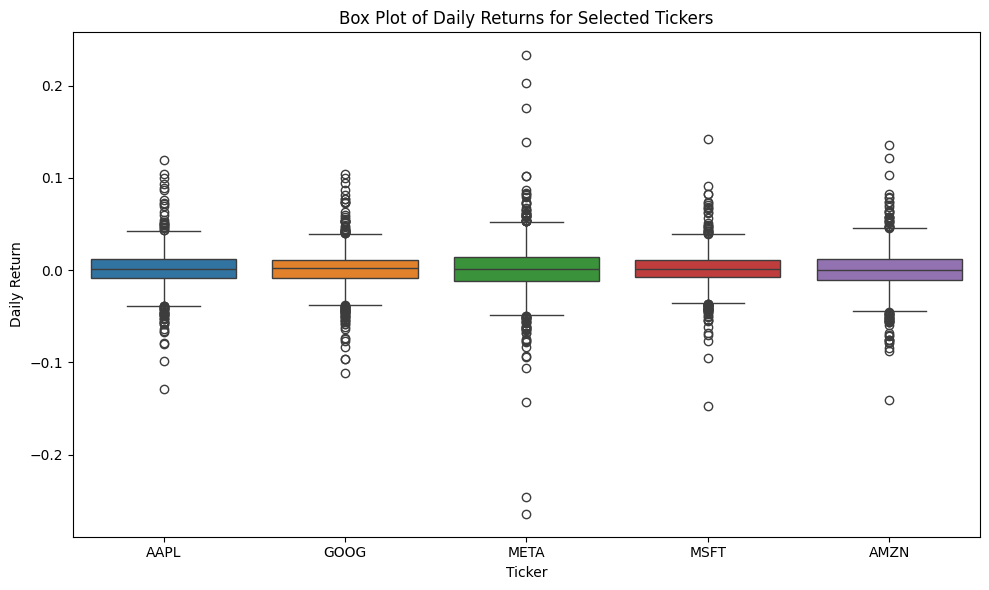

In [6]:
# Generate Box Plots of Daily Returns for all Tickers
# Compute daily returns and store in a DataFrame
returns_df = pd.DataFrame()

for ticker in tickers:
    df = ticker_data[ticker]
    df['Daily Return'] = df['Adj Close'].pct_change()
    returns_df[ticker] = df['Daily Return']

# Remove NaN values resulting from pct_change()
returns_df.dropna(inplace=True)

# Box plot of daily returns for all tickers
plt.figure(figsize=(10, 6))
sns.boxplot(data=returns_df)
plt.title('Box Plot of Daily Returns for Selected Tickers')
plt.ylabel('Daily Return')
plt.xlabel('Ticker')
plt.tight_layout()
plt.show()

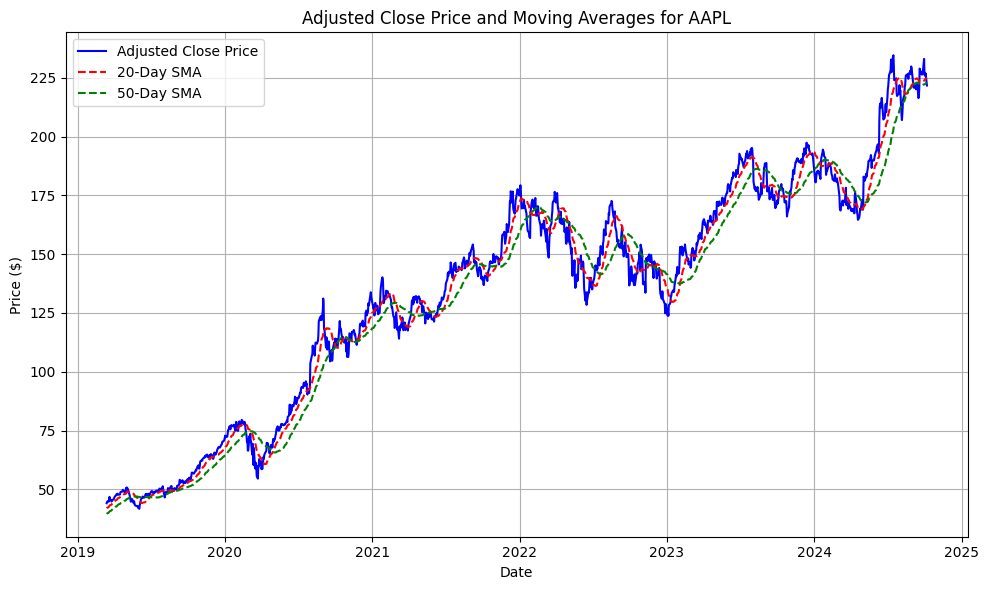

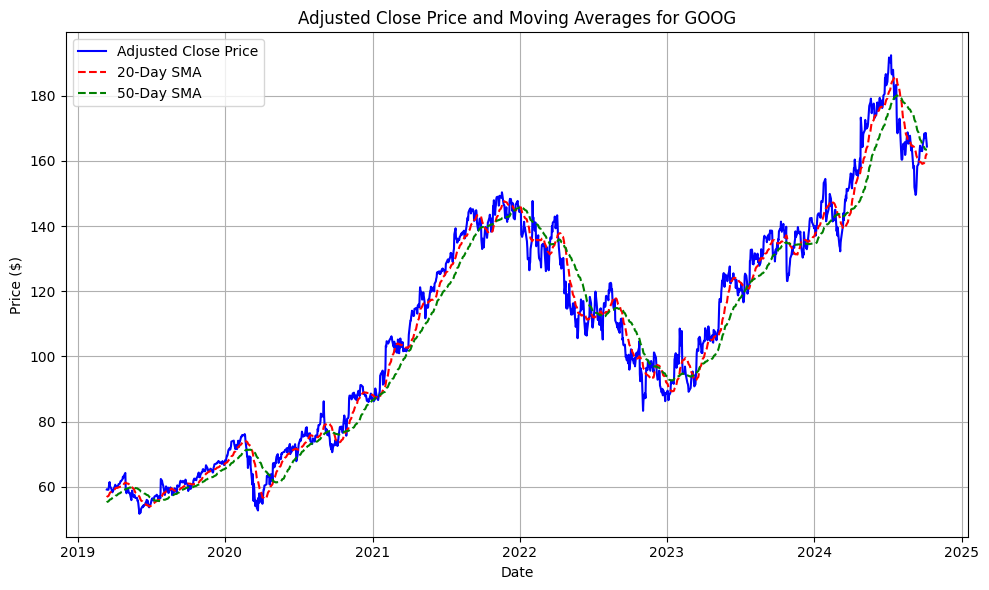

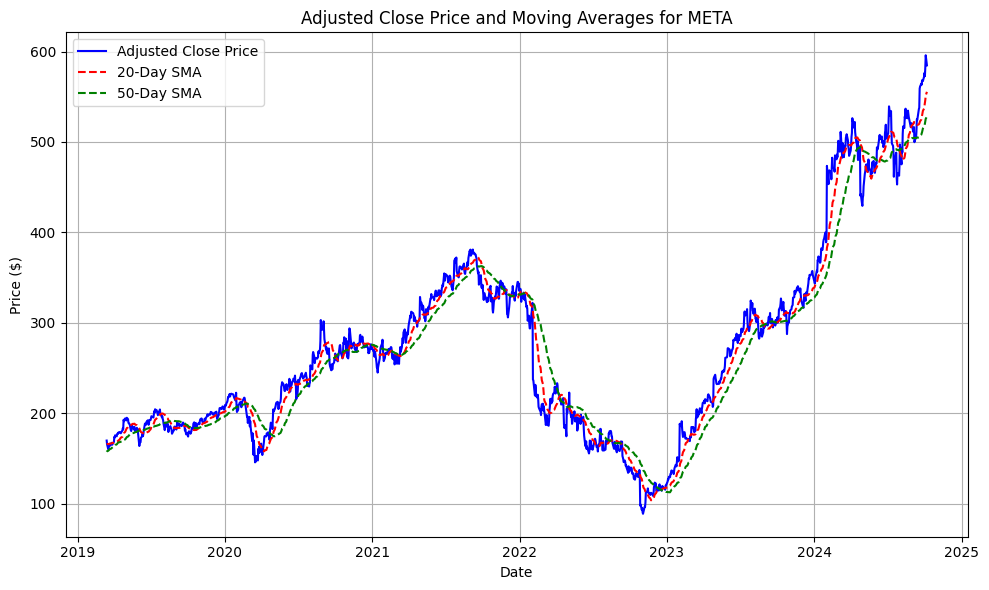

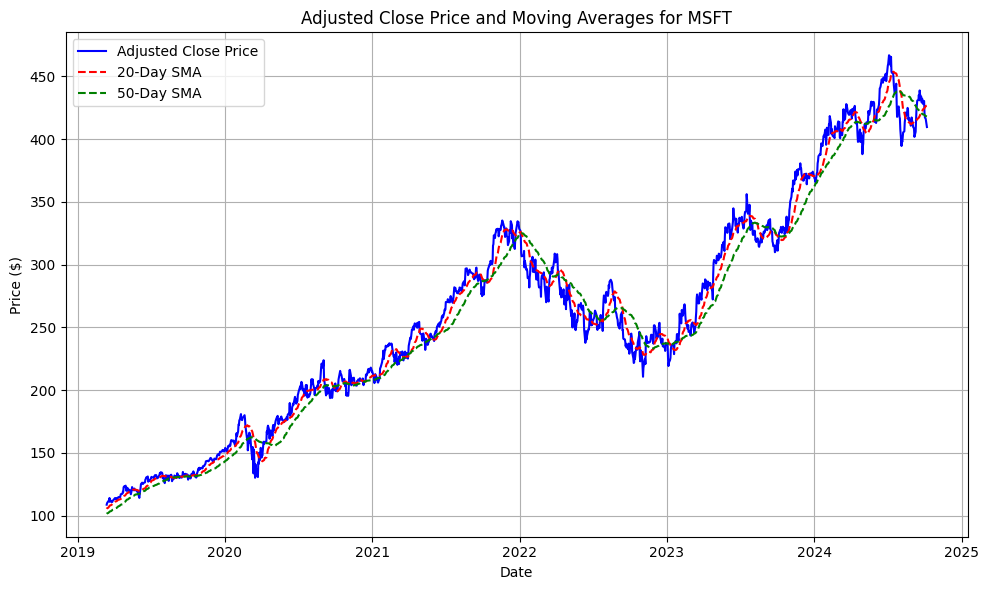

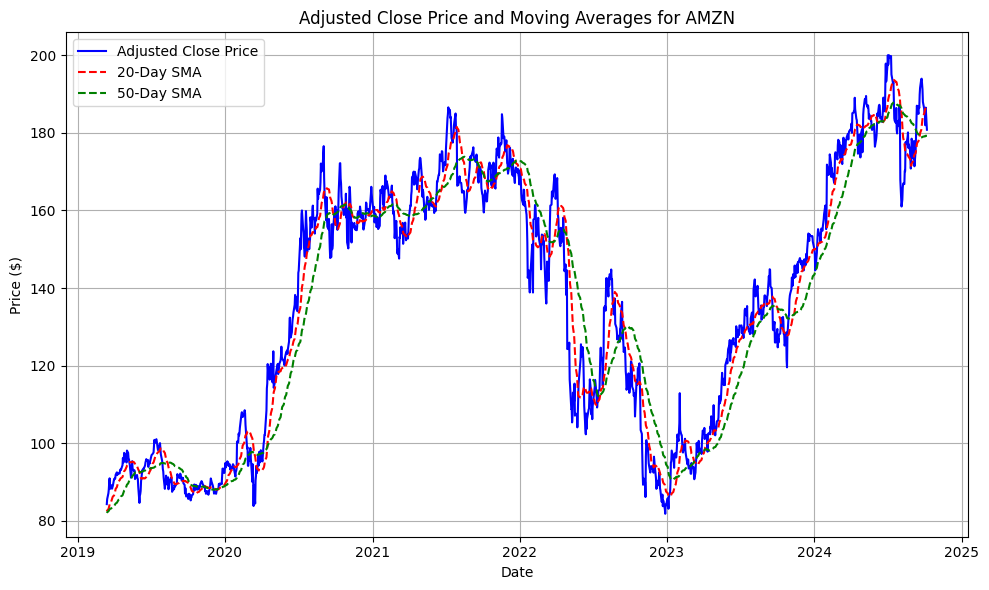

In [7]:
import matplotlib.pyplot as plt

# Generate Line Plots with Moving Averages for each Ticker
for ticker in tickers:
    df = ticker_data[ticker]
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['Adj Close'], label='Adjusted Close Price', color='blue')
    plt.plot(df.index, df['SMA_20'], label='20-Day SMA', color='red', linestyle='--')
    plt.plot(df.index, df['SMA_50'], label='50-Day SMA', color='green', linestyle='--')
    plt.title(f'Adjusted Close Price and Moving Averages for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [8]:
pip install mplfinance


Note: you may need to restart the kernel to use updated packages.


/var/folders/ww/g22rd79j2xgfxy8trypcnk200000gn/T/ipykernel_97697/1243527713.py:9: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead

/var/folders/ww/g22rd79j2xgfxy8trypcnk200000gn/T/ipykernel_97697/1243527713.py:9: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



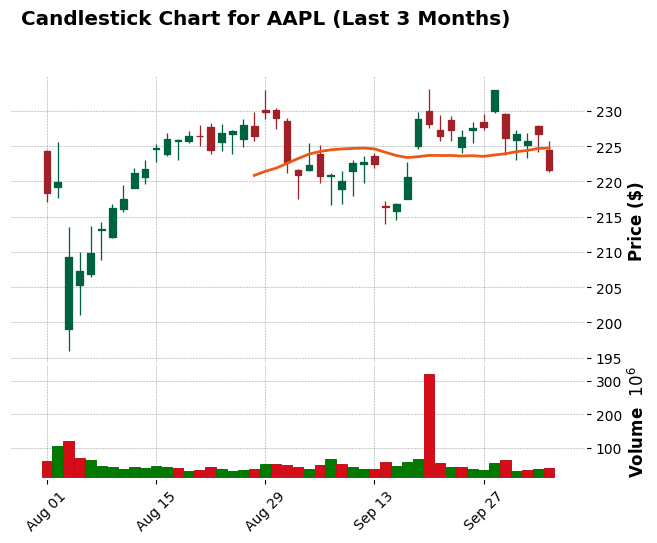

/var/folders/ww/g22rd79j2xgfxy8trypcnk200000gn/T/ipykernel_97697/1243527713.py:9: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead

/var/folders/ww/g22rd79j2xgfxy8trypcnk200000gn/T/ipykernel_97697/1243527713.py:9: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



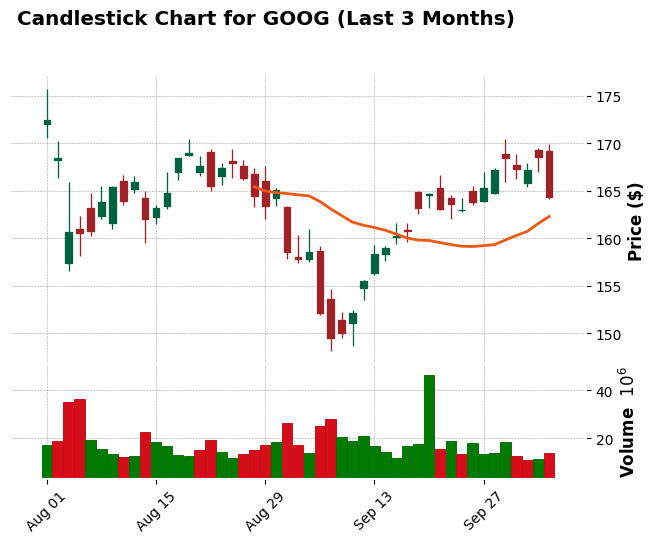

/var/folders/ww/g22rd79j2xgfxy8trypcnk200000gn/T/ipykernel_97697/1243527713.py:9: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead

/var/folders/ww/g22rd79j2xgfxy8trypcnk200000gn/T/ipykernel_97697/1243527713.py:9: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



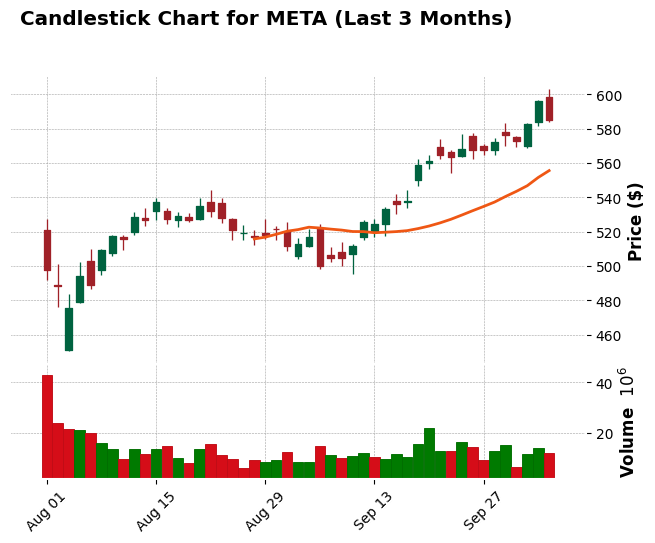

/var/folders/ww/g22rd79j2xgfxy8trypcnk200000gn/T/ipykernel_97697/1243527713.py:9: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead

/var/folders/ww/g22rd79j2xgfxy8trypcnk200000gn/T/ipykernel_97697/1243527713.py:9: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



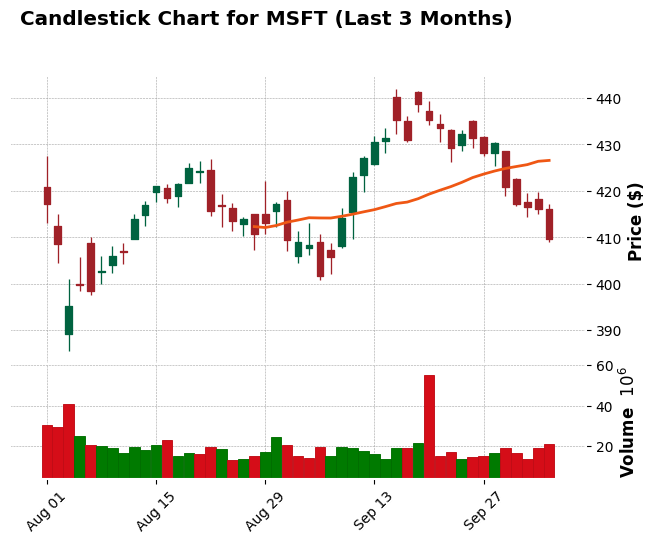

/var/folders/ww/g22rd79j2xgfxy8trypcnk200000gn/T/ipykernel_97697/1243527713.py:9: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead

/var/folders/ww/g22rd79j2xgfxy8trypcnk200000gn/T/ipykernel_97697/1243527713.py:9: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



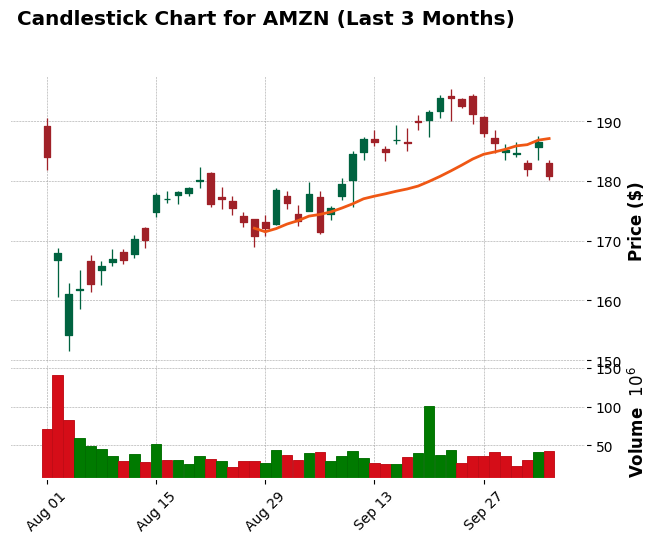

In [9]:
import mplfinance as mpf

# Generate Candlestick Charts for each Ticker
for ticker in tickers:
    df = ticker_data[ticker]
    df = df.copy()
    df.index.name = 'Date'
    # Select a subset for better visibility (e.g., last 3 months)
    subset = df.last('3M')
    mpf.plot(subset, type='candle', style='charles',
             title=f'Candlestick Chart for {ticker} (Last 3 Months)',
             ylabel='Price ($)',
             volume=True,
             mav=(20, 50),
             show_nontrading=False)


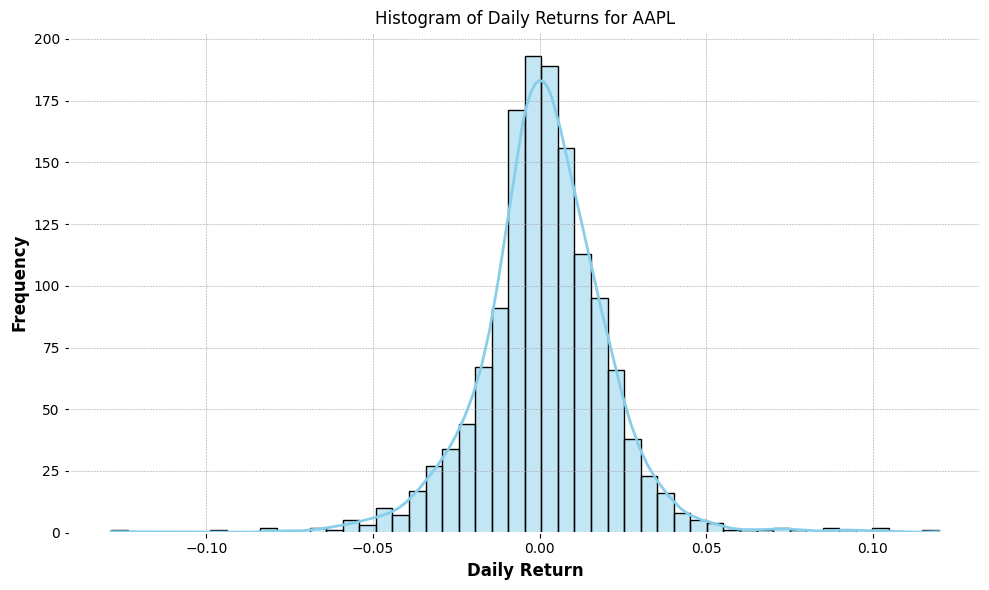

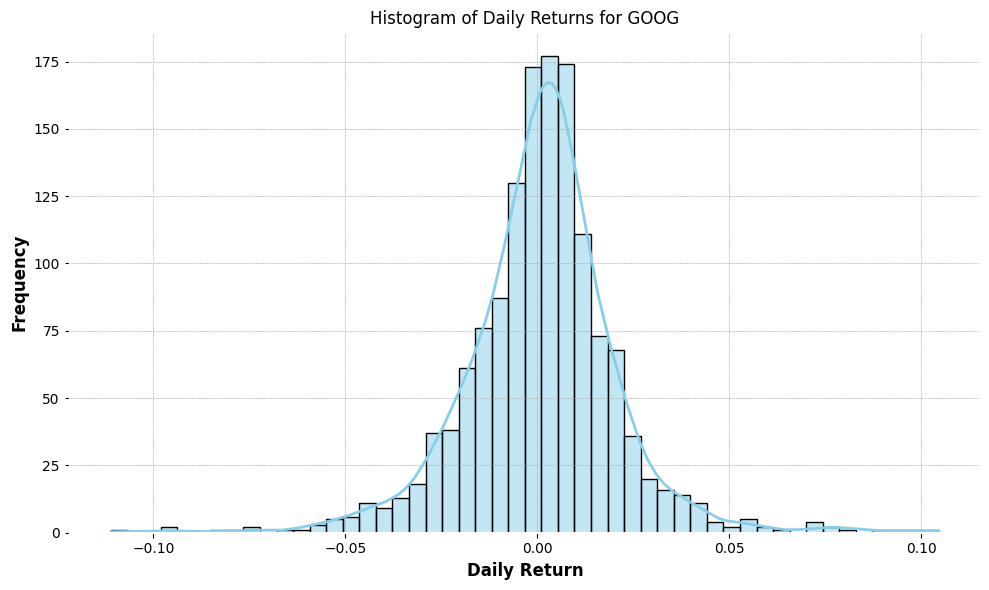

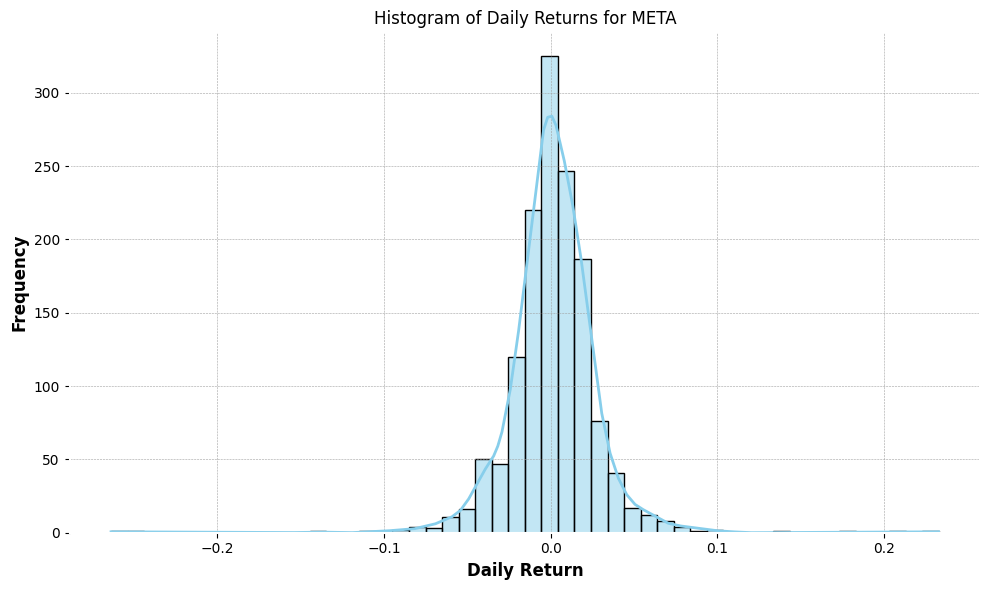

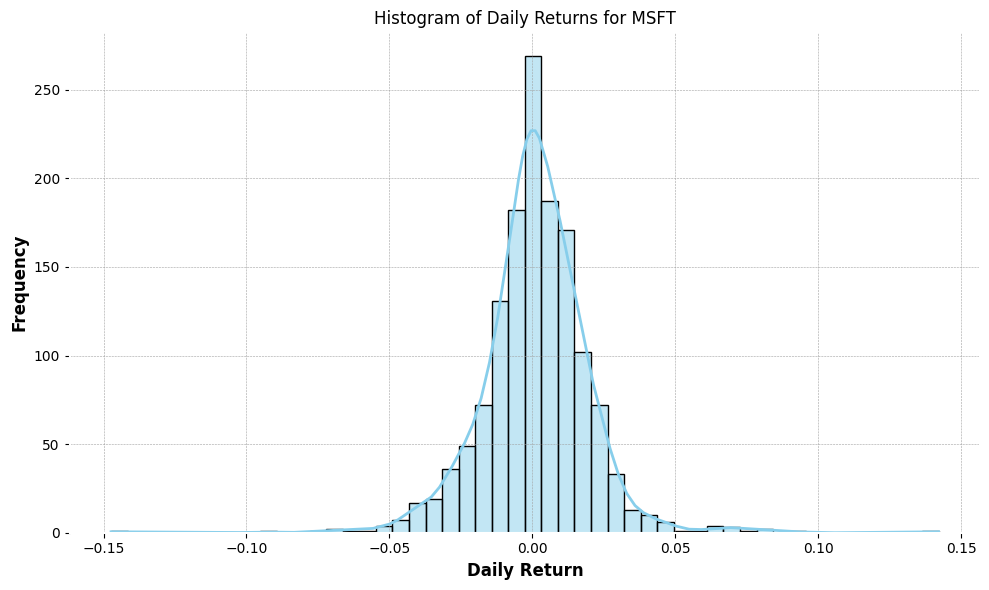

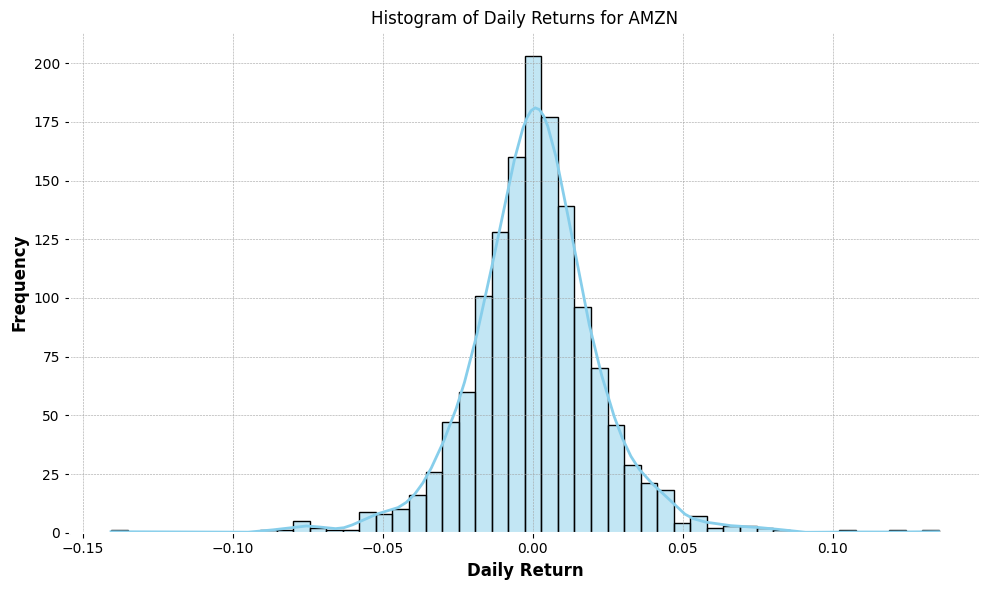

In [10]:
# Generate Histograms of Daily Returns for each Ticker
for ticker in tickers:
    df = ticker_data[ticker]
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Daily Return'], bins=50, kde=True, color='skyblue')
    plt.title(f'Histogram of Daily Returns for {ticker}')
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


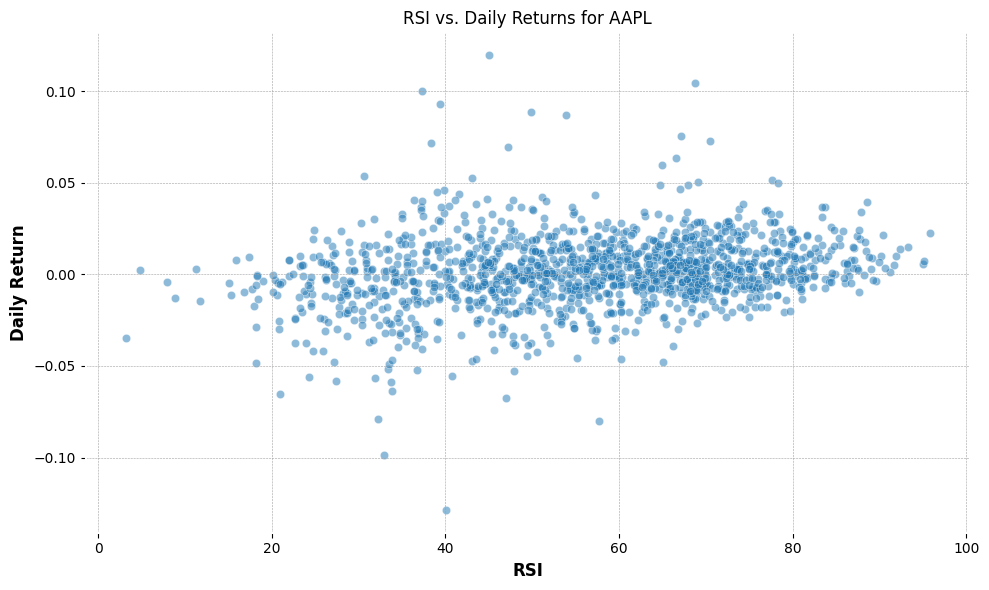

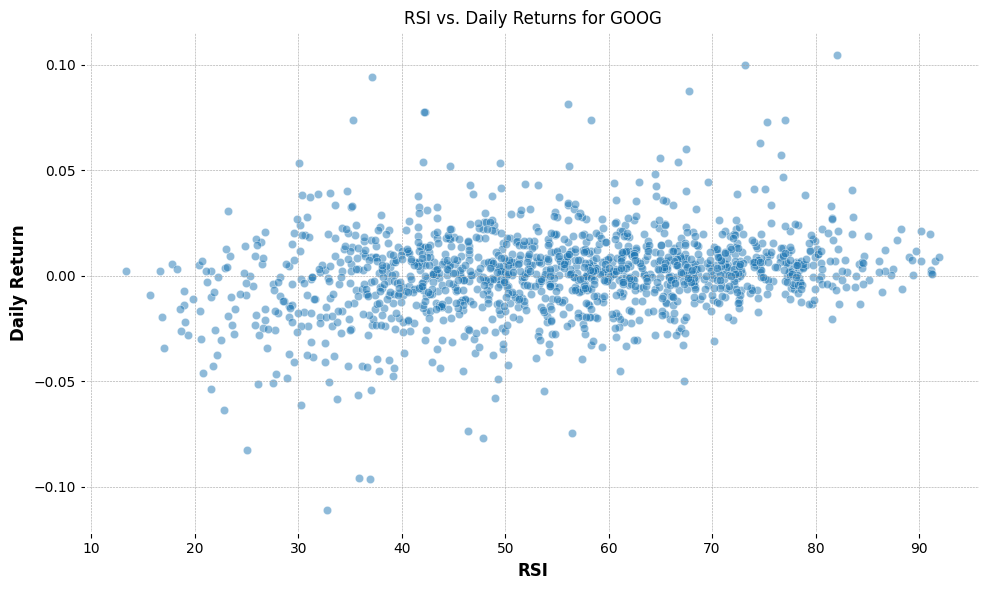

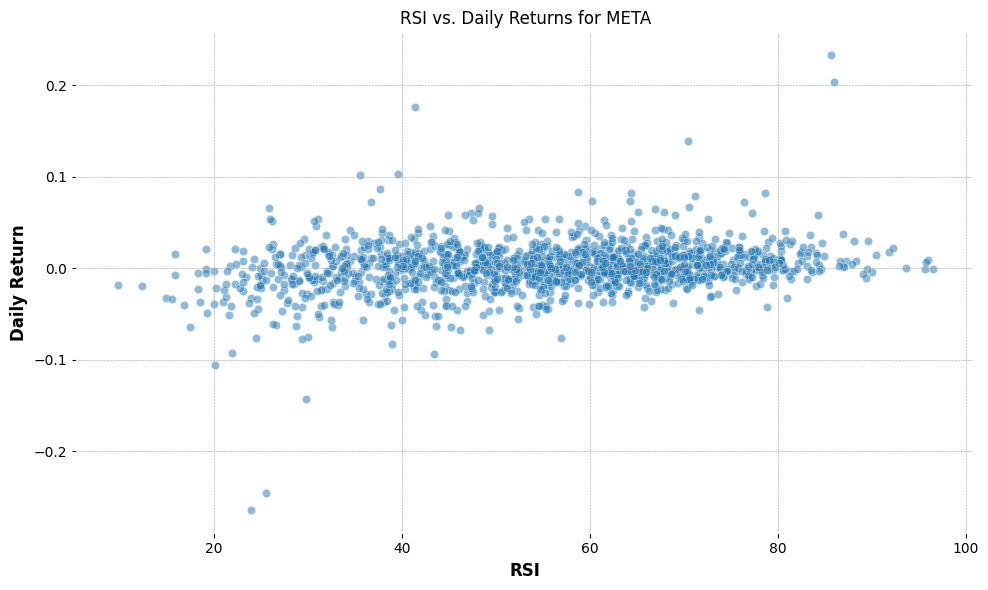

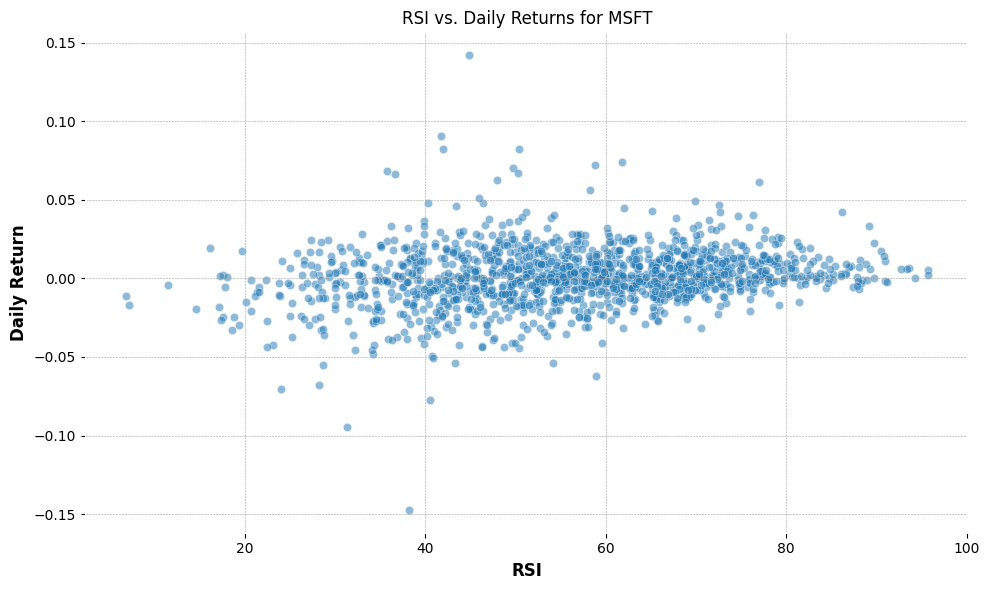

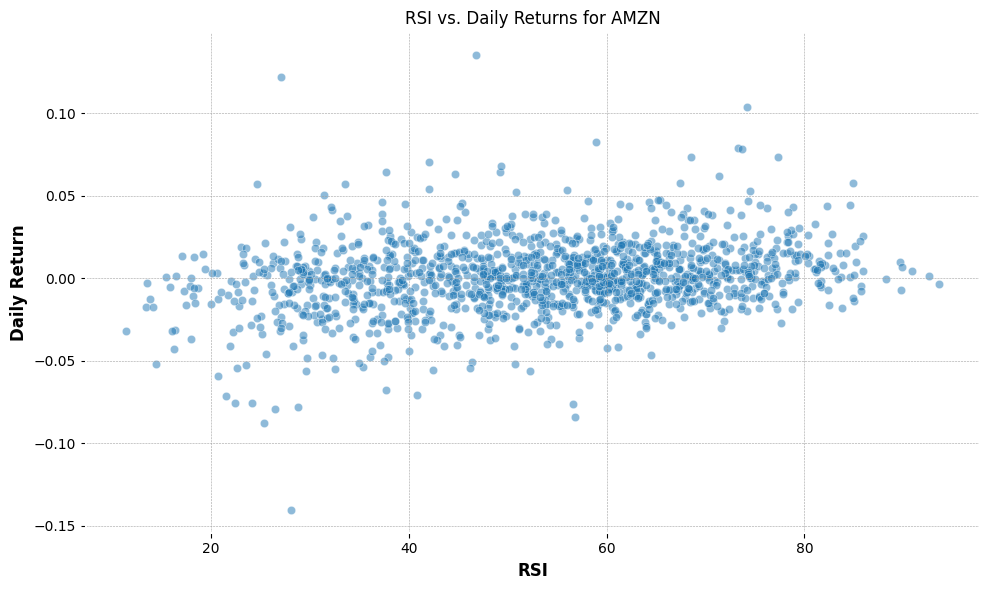

In [11]:
# Generate Scatter Plots of RSI vs. Daily Returns for each Ticker
for ticker in tickers:
    df = ticker_data[ticker]
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='RSI', y='Daily Return', data=df, alpha=0.5)
    plt.title(f'RSI vs. Daily Returns for {ticker}')
    plt.xlabel('RSI')
    plt.ylabel('Daily Return')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


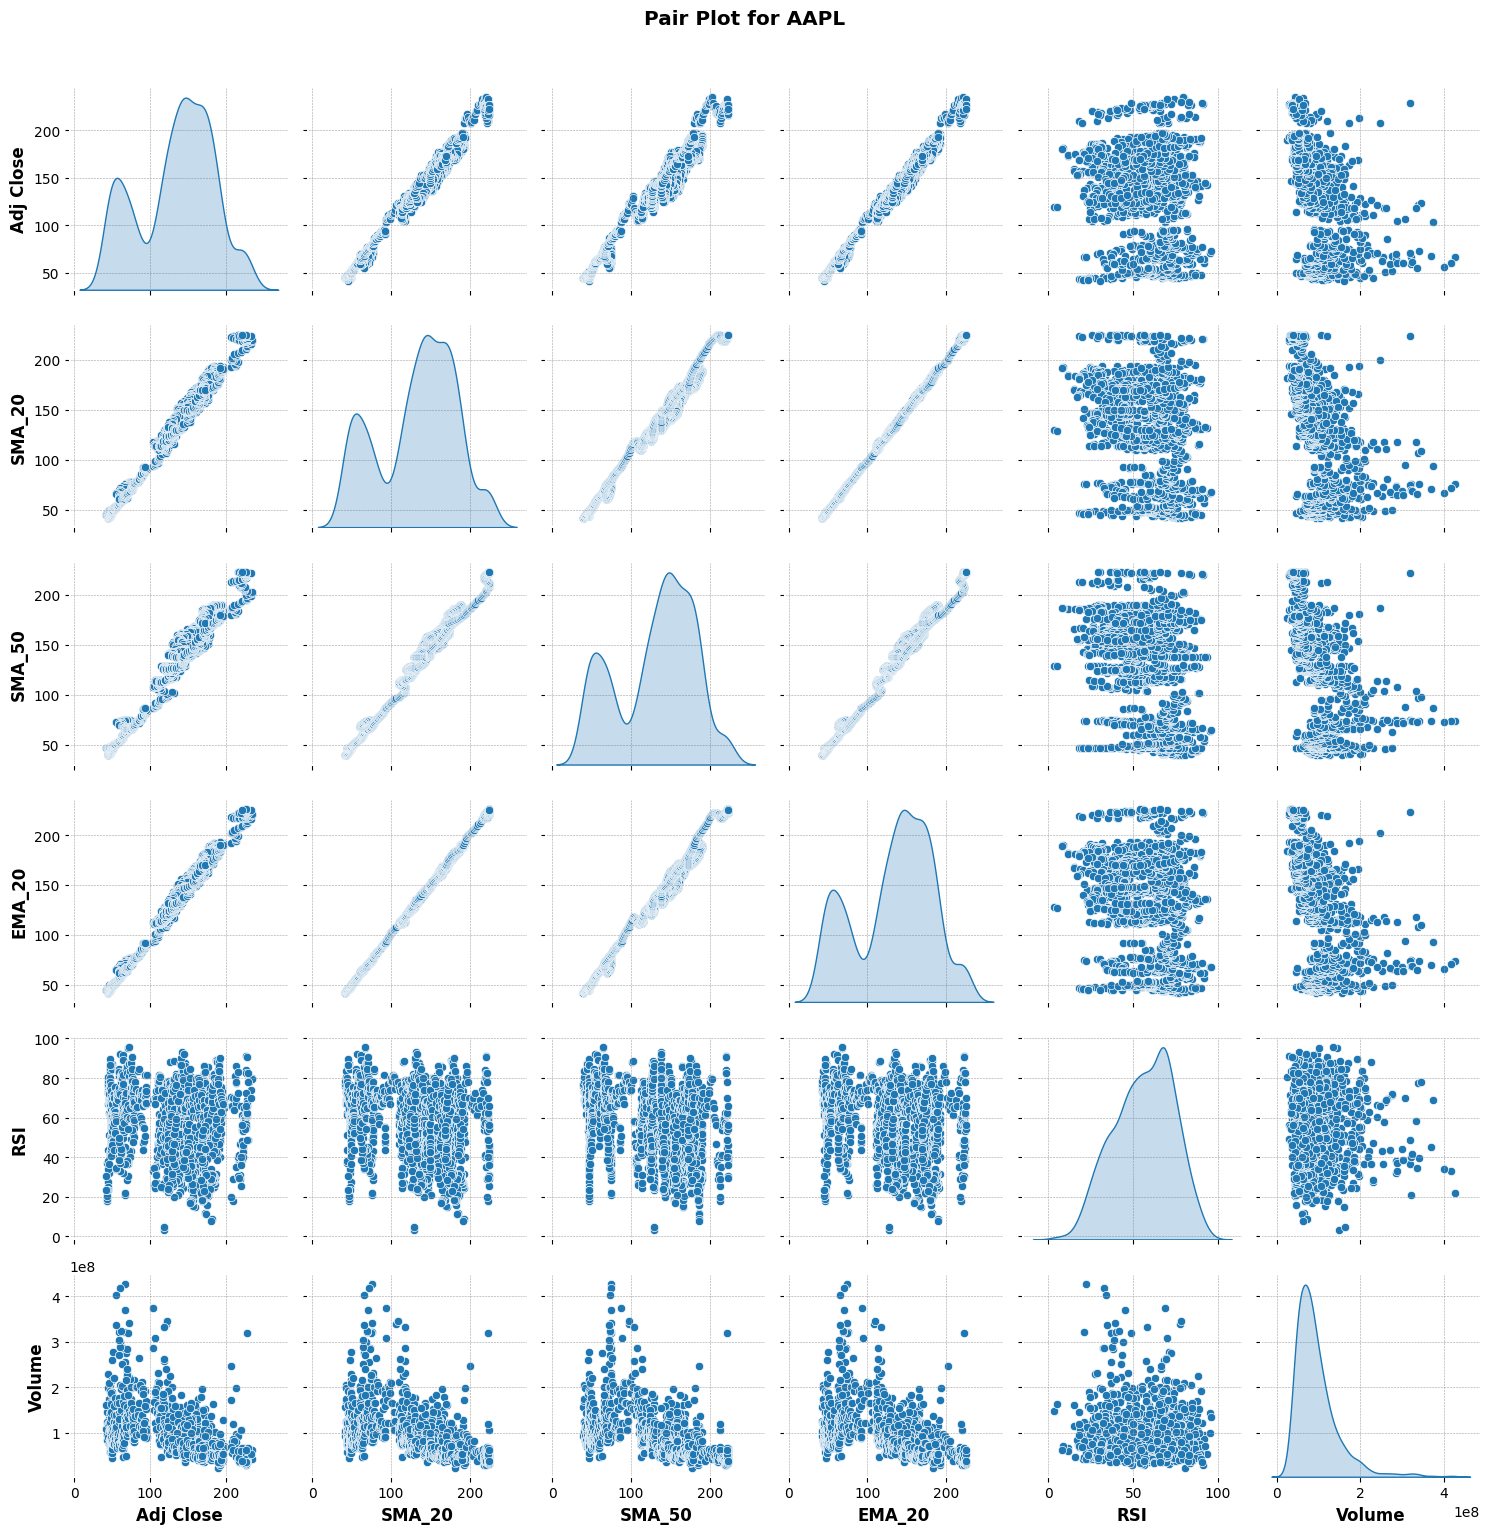

In [12]:
# Generate Pair Plots for one Ticker (e.g., AAPL) as an example
# You can loop through all tickers if needed
ticker = 'AAPL'
df = ticker_data[ticker]
selected_features = ['Adj Close', 'SMA_20', 'SMA_50', 'EMA_20', 'RSI', 'Volume']
sns.pairplot(df[selected_features].dropna(), diag_kind='kde')
plt.suptitle(f'Pair Plot for {ticker}', y=1.02)
plt.tight_layout()
plt.show()


In [13]:
pip install statsmodels


Note: you may need to restart the kernel to use updated packages.


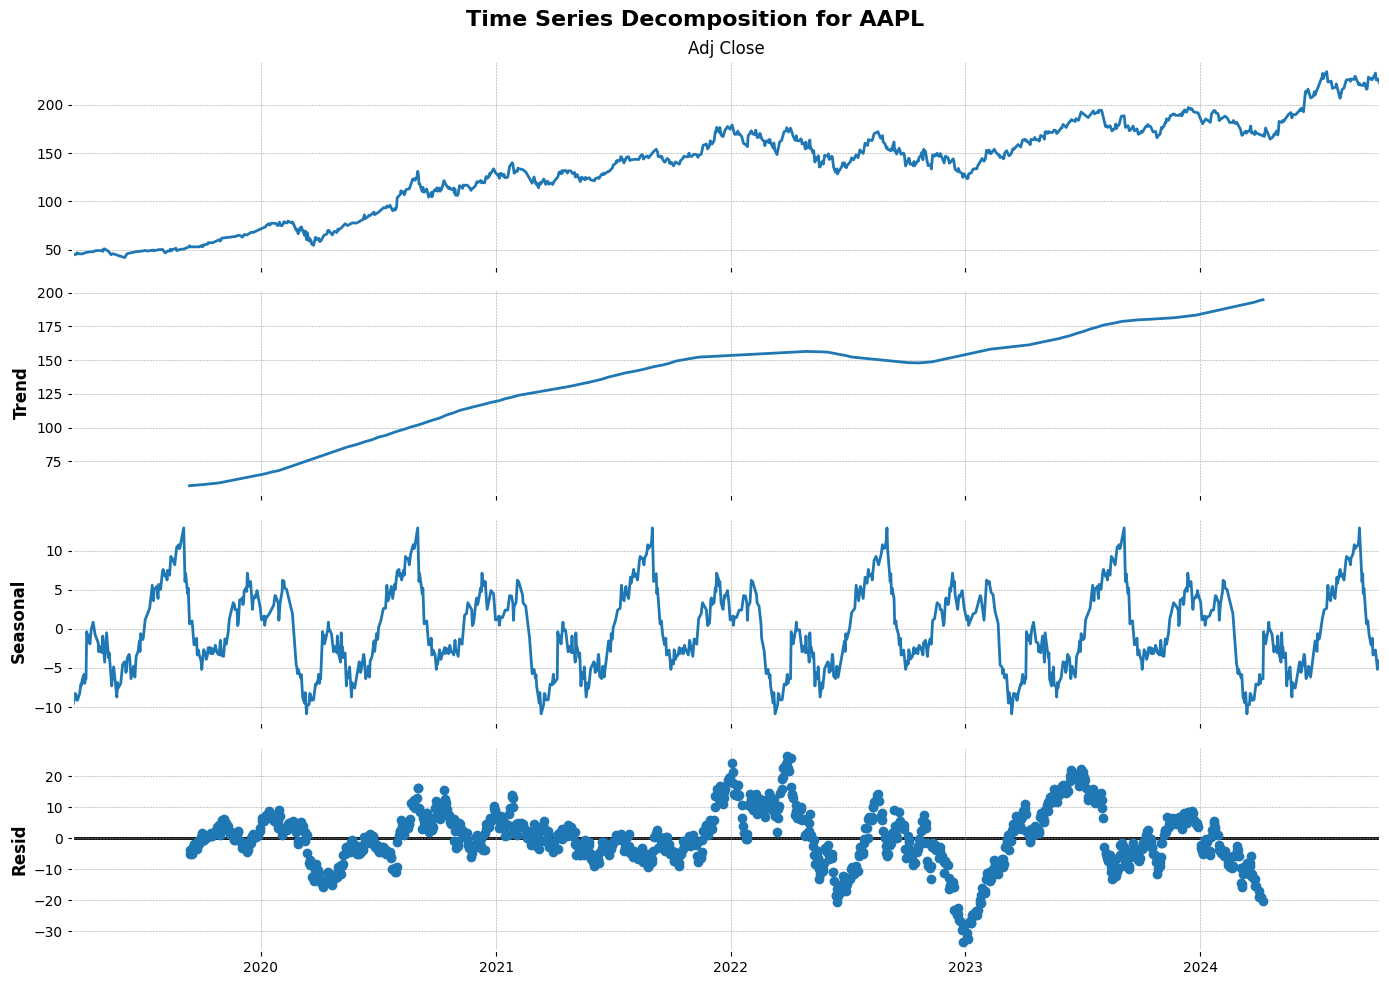

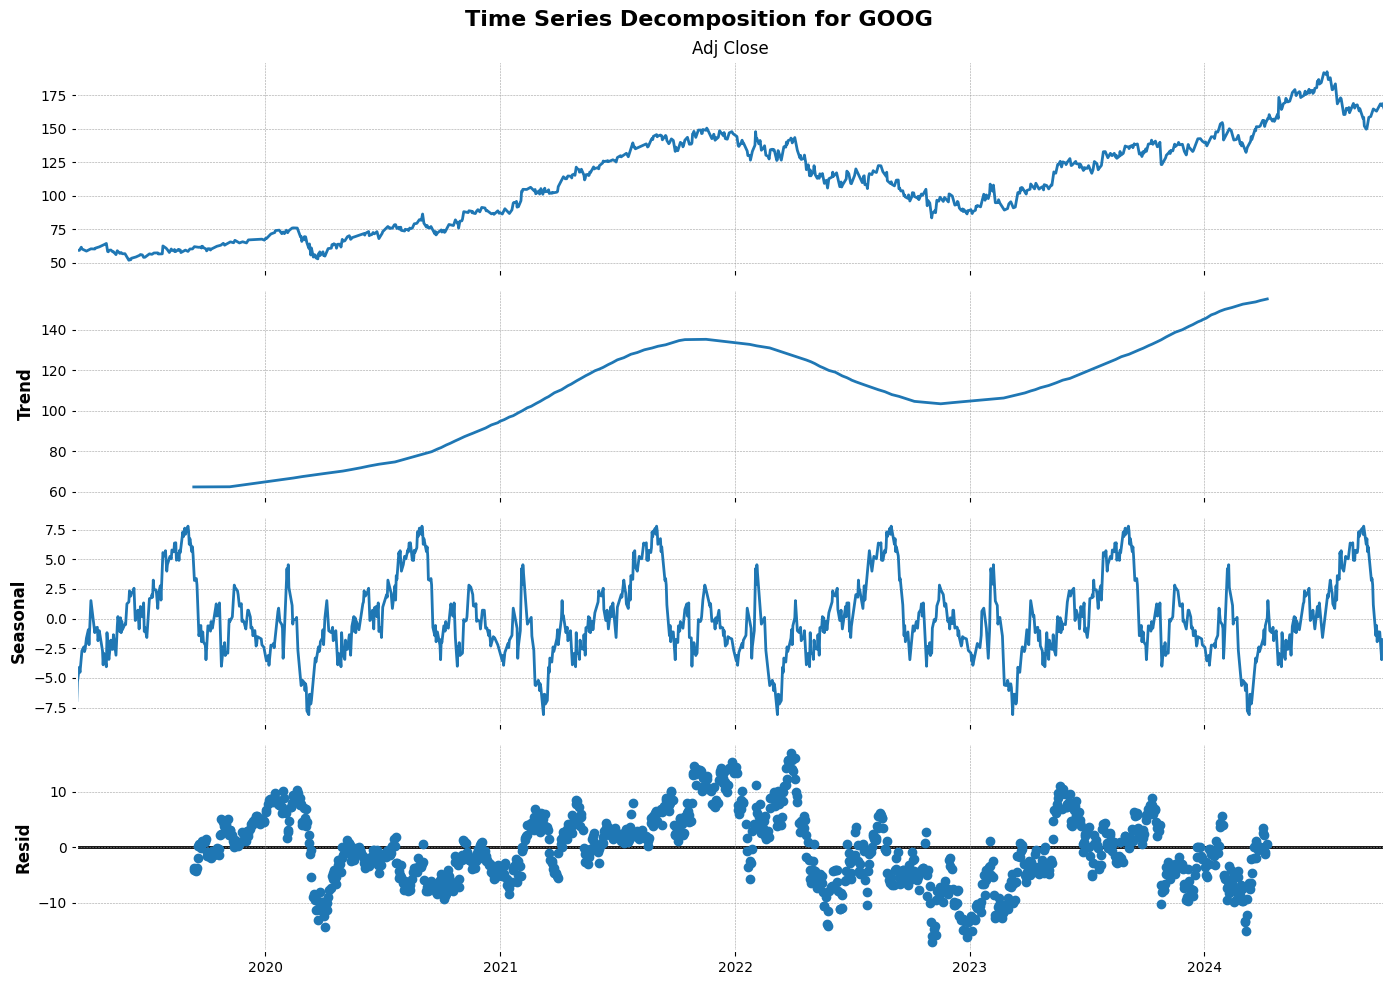

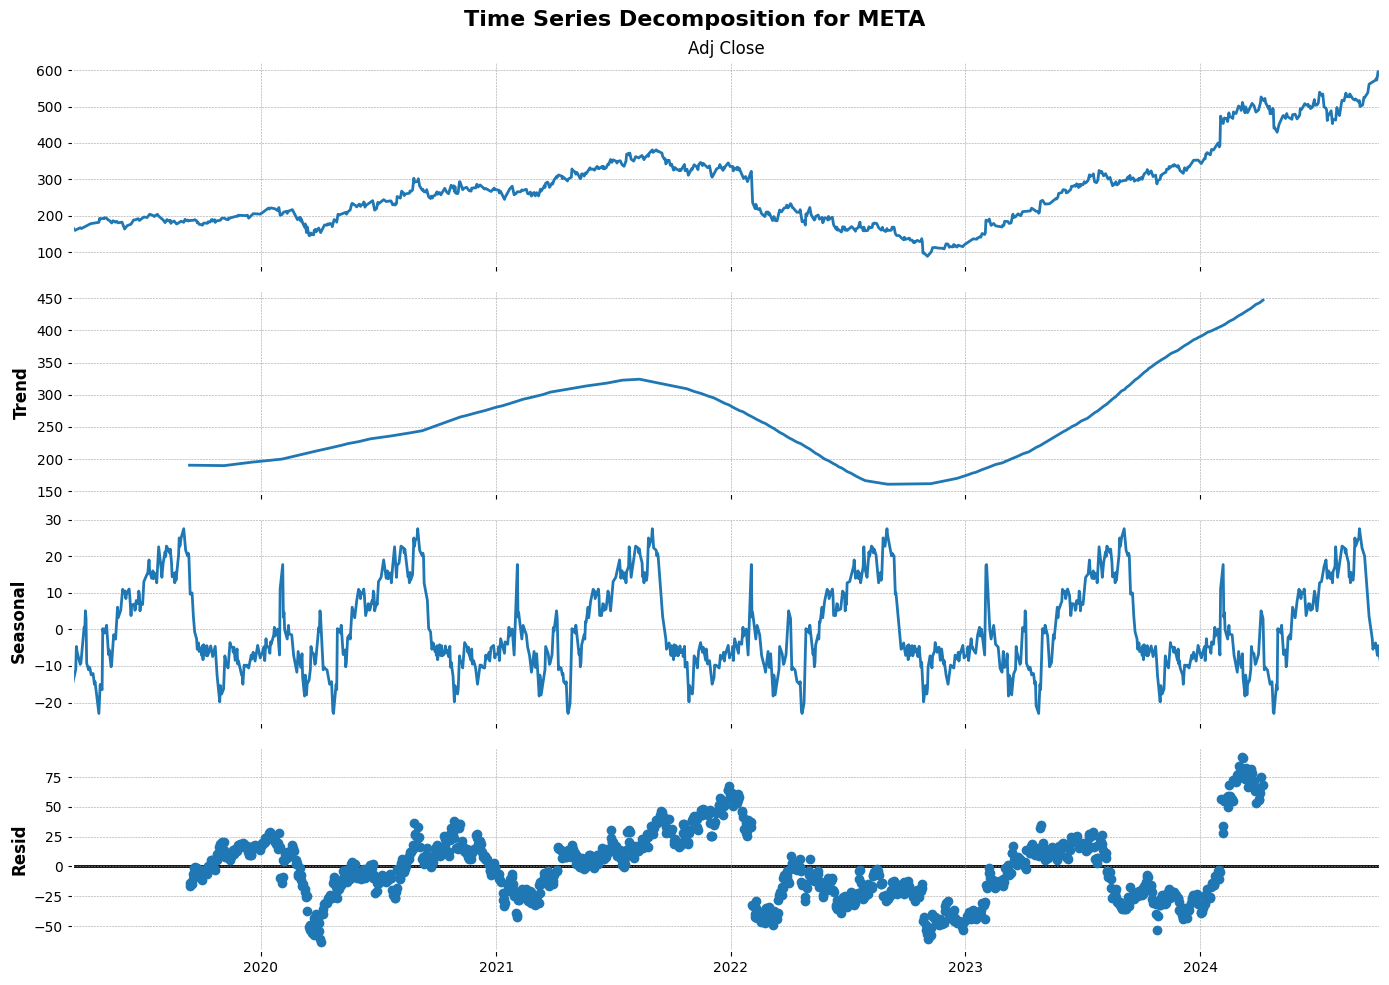

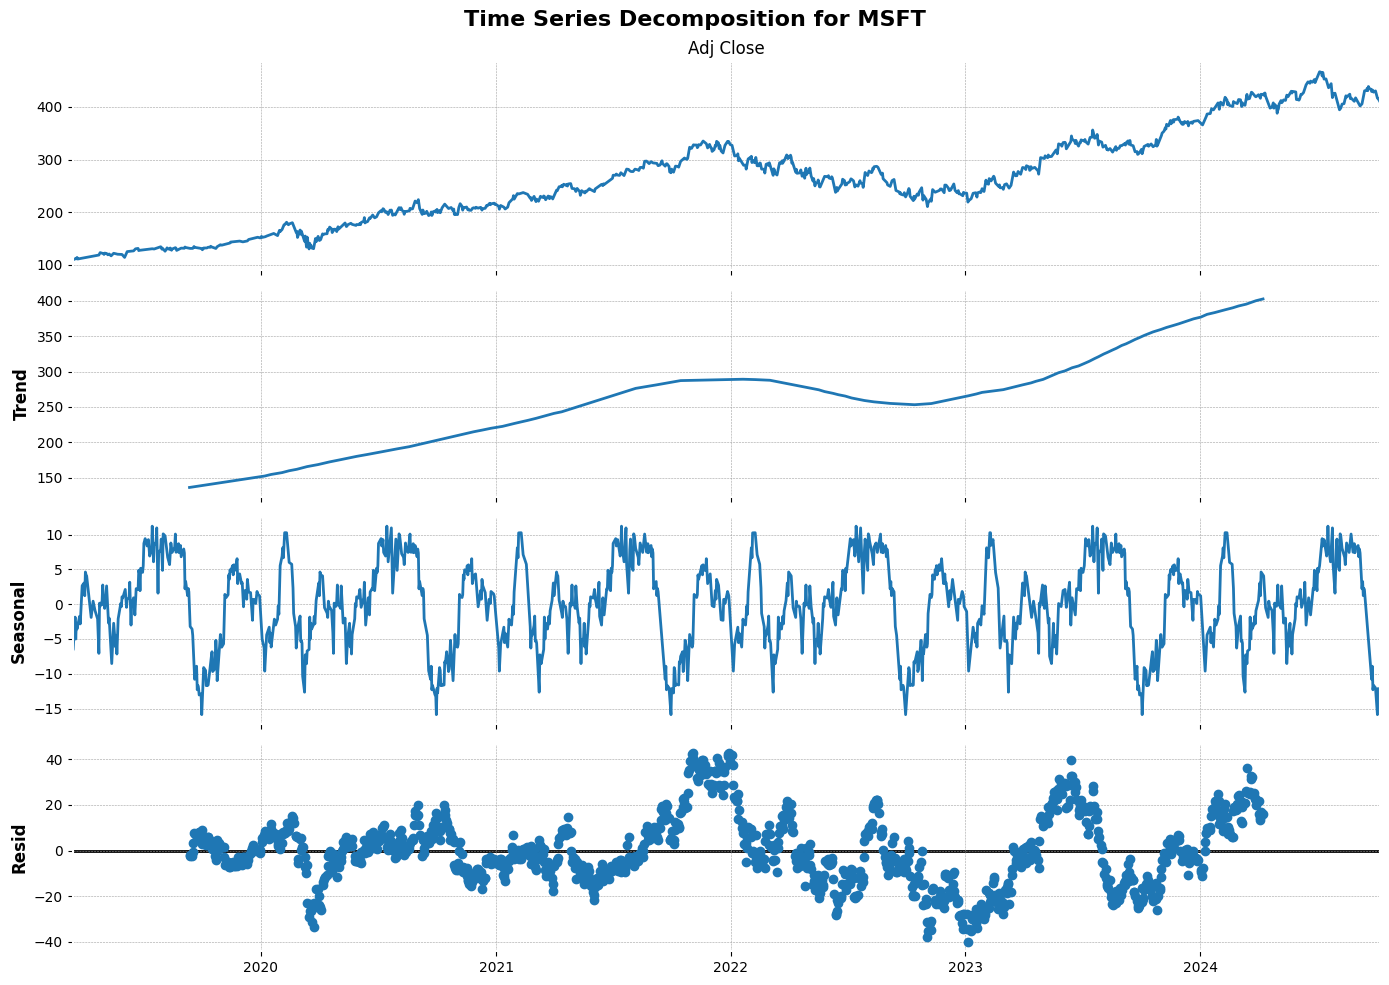

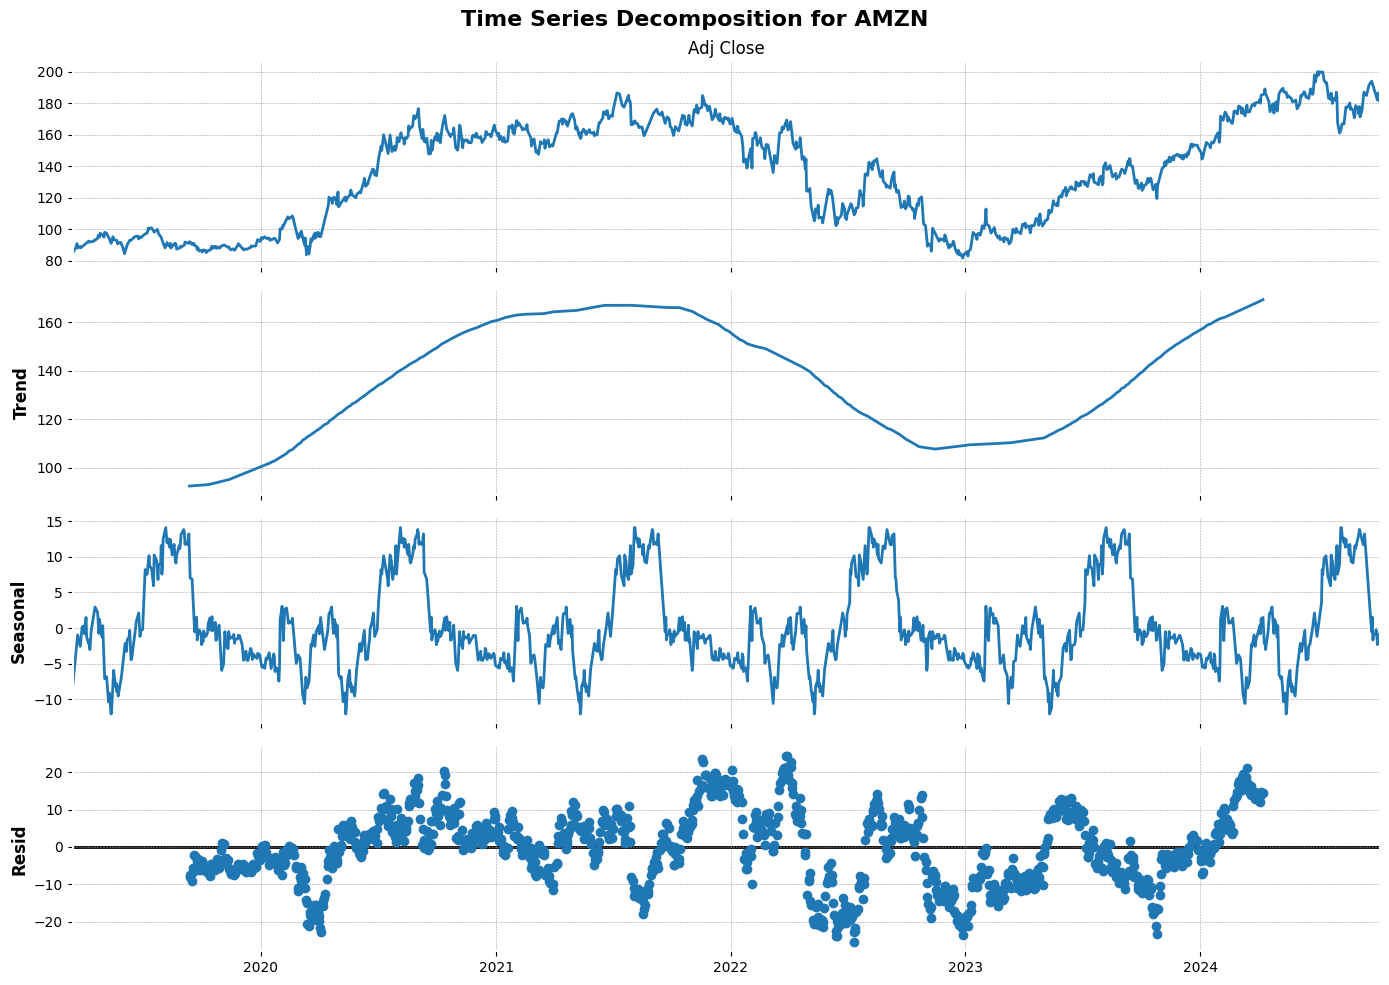

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Generate Time Series Decomposition for each Ticker
for ticker in tickers:
    df = ticker_data[ticker]
    df = df.copy()
    df.set_index('Date', inplace=True) if 'Date' in df.columns else df
    decomposition = seasonal_decompose(df['Adj Close'], model='additive', period=252)  # Approx. trading days in a year
    fig = decomposition.plot()
    fig.set_size_inches(14, 10)
    plt.suptitle(f'Time Series Decomposition for {ticker}', fontsize=16)
    plt.tight_layout()
    plt.show()


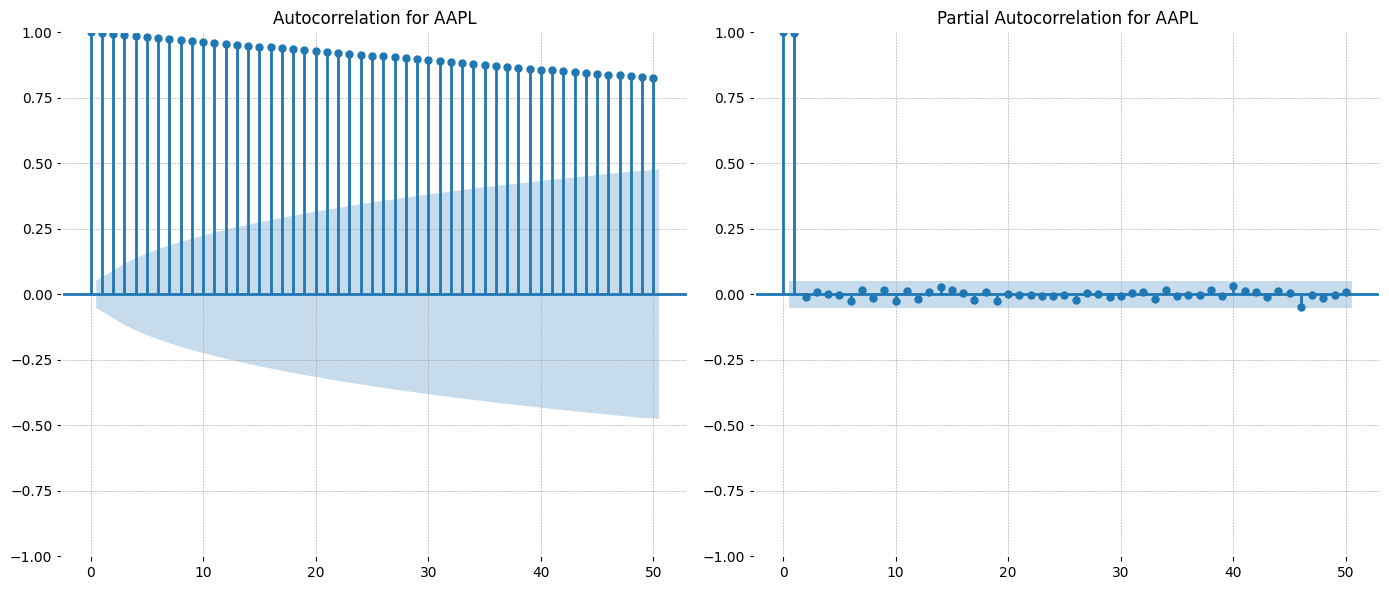

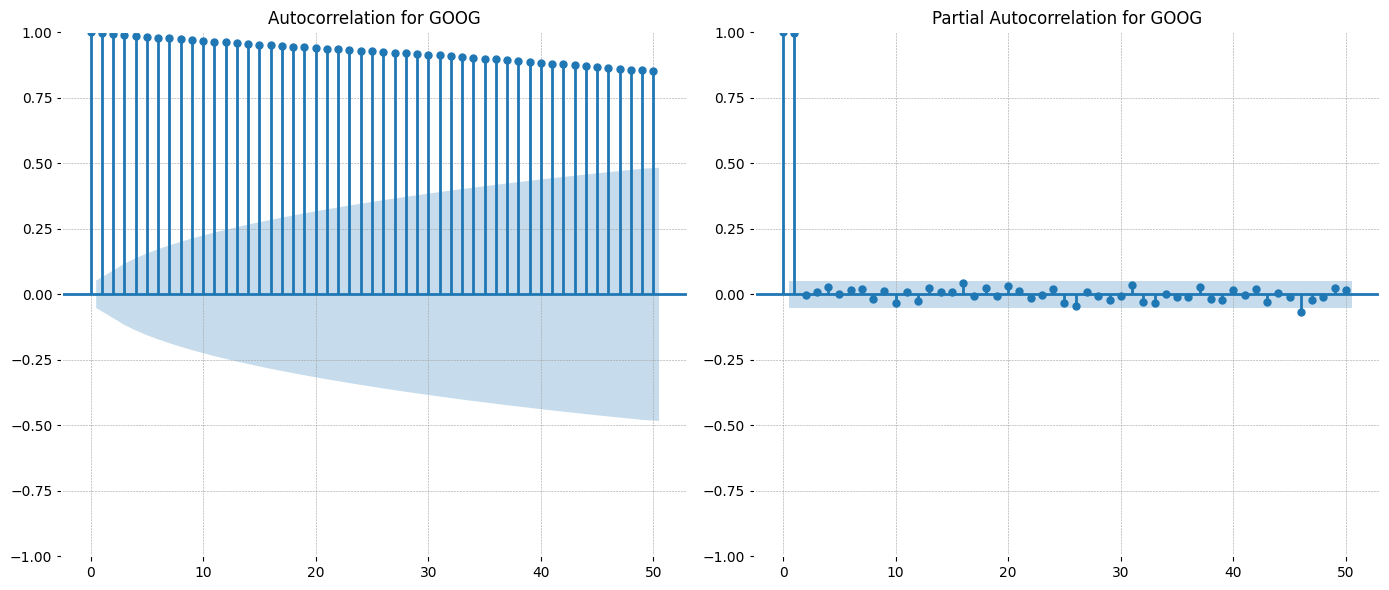

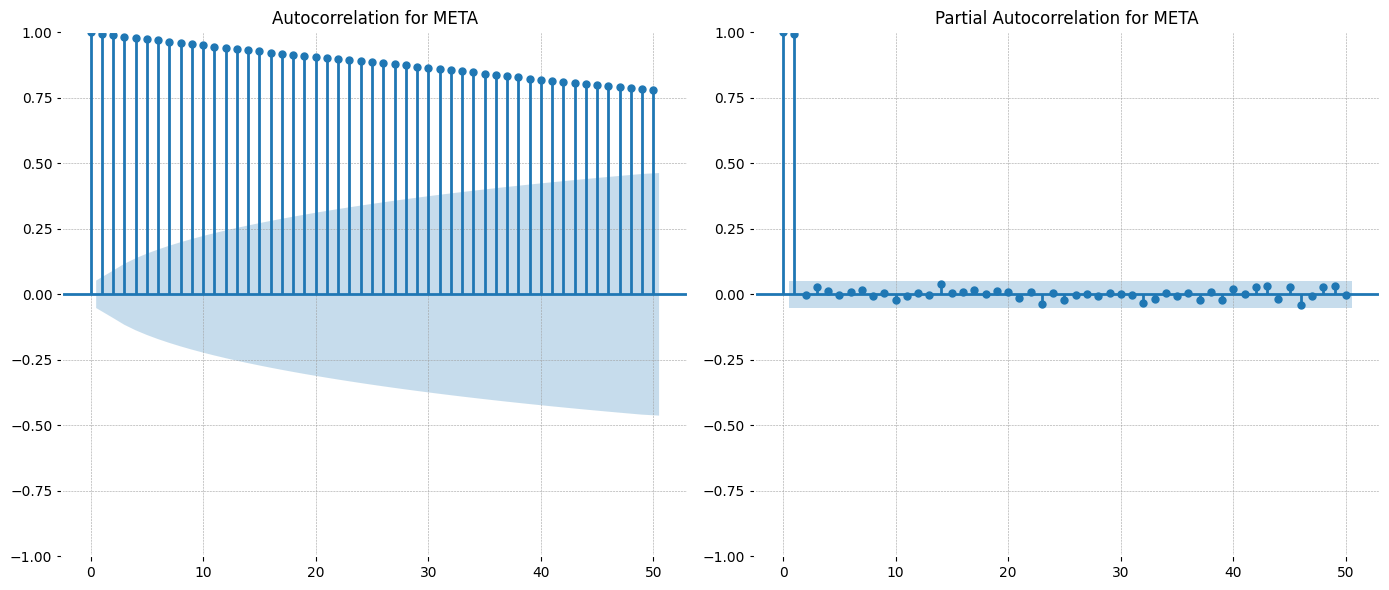

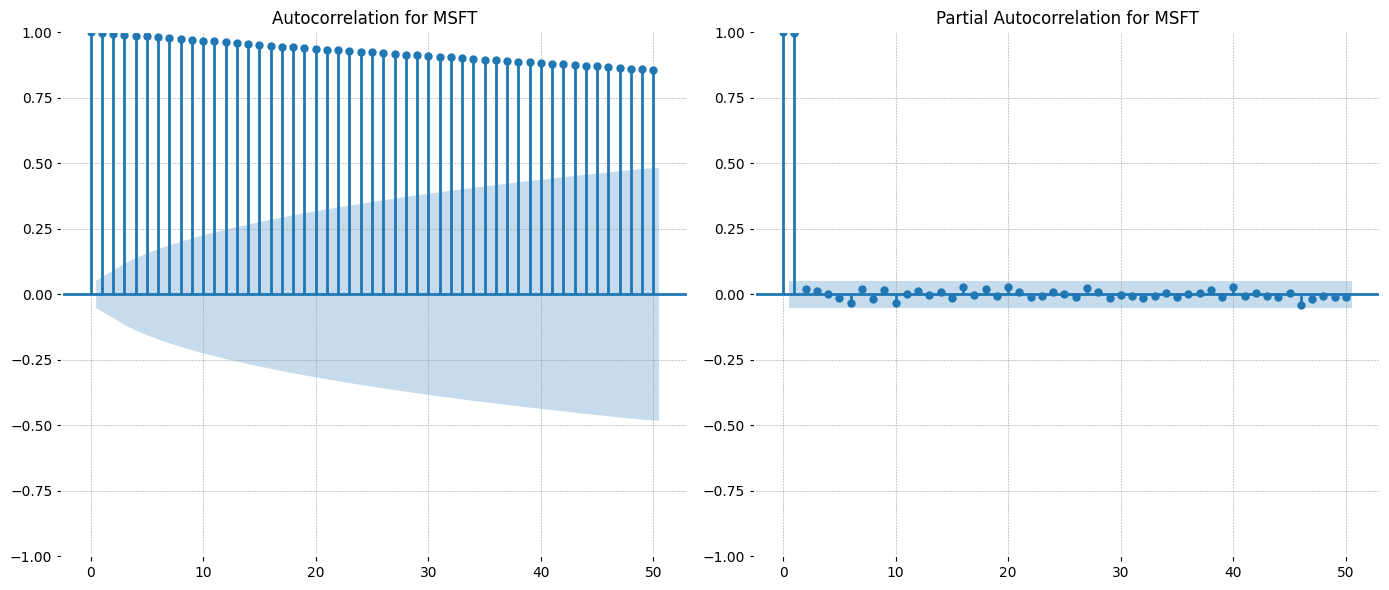

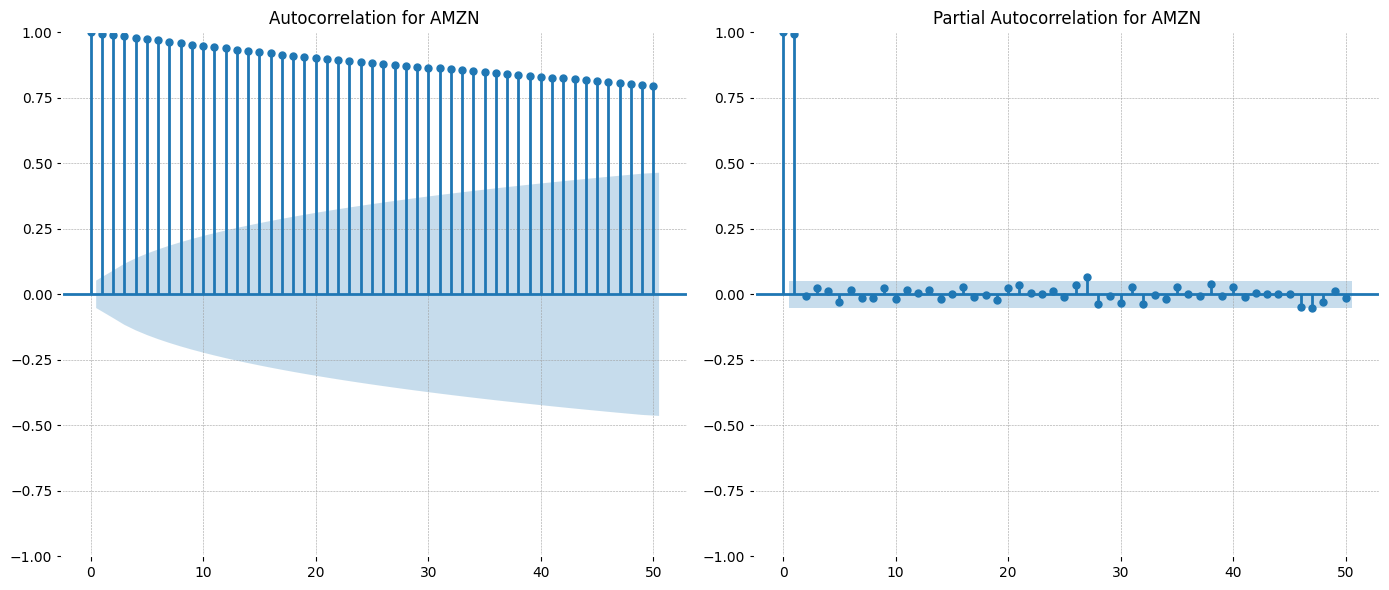

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Generate Autocorrelation and Partial Autocorrelation Plots for each Ticker
for ticker in tickers:
    df = ticker_data[ticker]
    plt.figure(figsize=(14, 6))

    # Autocorrelation Plot
    plt.subplot(1, 2, 1)
    plot_acf(df['Adj Close'], ax=plt.gca(), lags=50)
    plt.title(f'Autocorrelation for {ticker}')

    # Partial Autocorrelation Plot
    plt.subplot(1, 2, 2)
    plot_pacf(df['Adj Close'], ax=plt.gca(), lags=50, method='ywm')
    plt.title(f'Partial Autocorrelation for {ticker}')

    plt.tight_layout()
    plt.show()


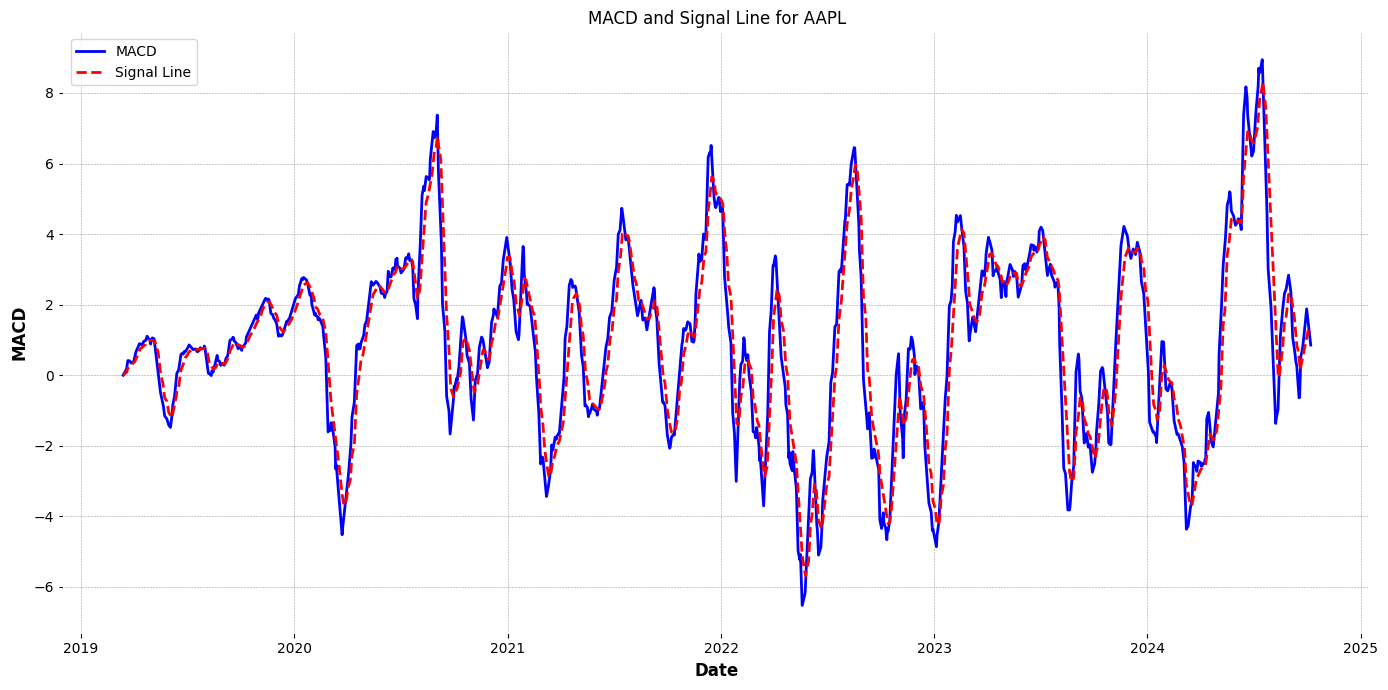

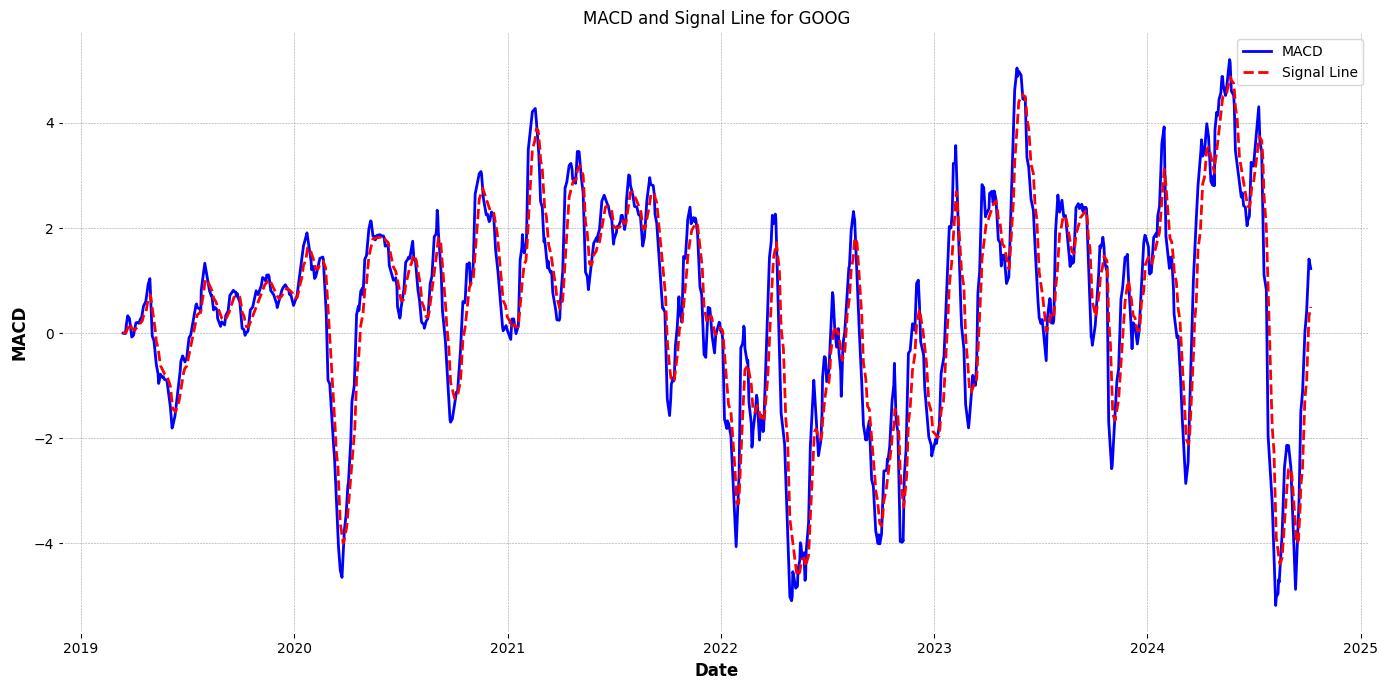

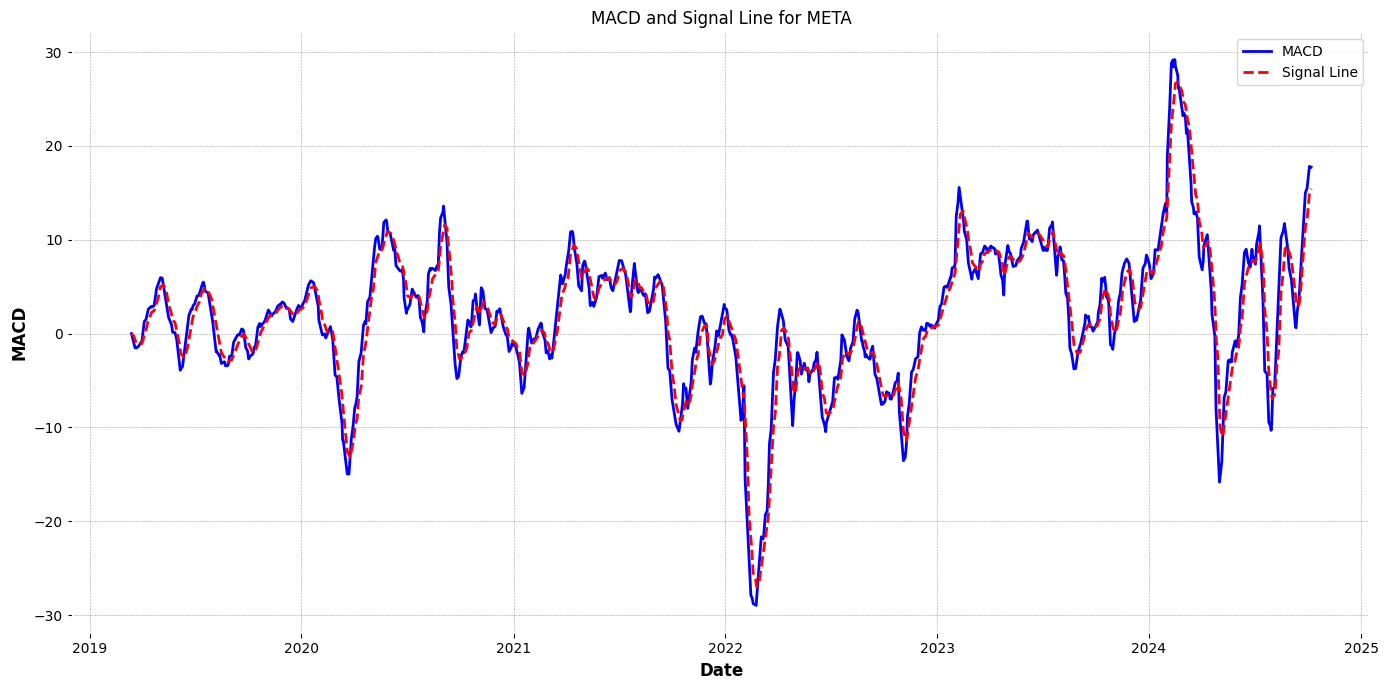

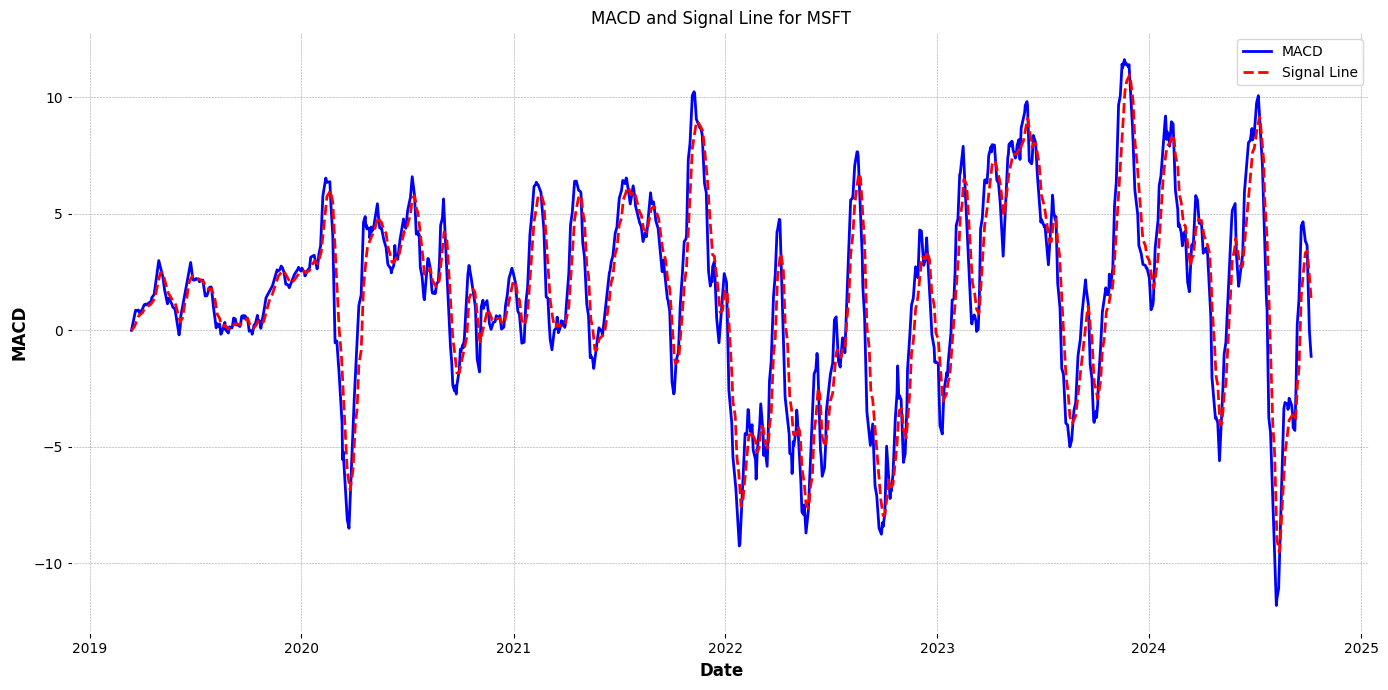

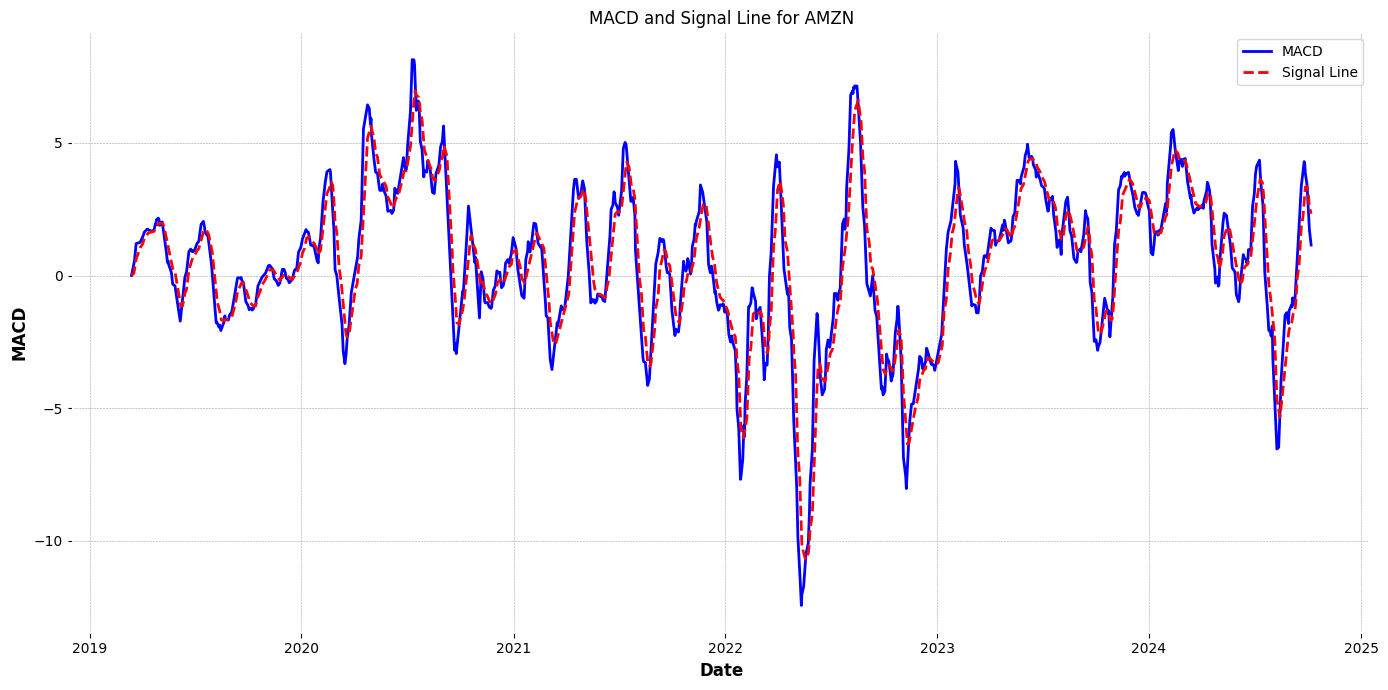

In [16]:
# Function to calculate MACD
def calculate_macd(df):
    """
    Calculates MACD and Signal Line indicators.

    Args:
        df (pd.DataFrame): DataFrame containing 'Adj Close' prices.

    Returns:
        pd.DataFrame: DataFrame with 'MACD' and 'Signal_Line' columns added.
    """
    df = df.copy()
    df['MACD'] = df['Adj Close'].ewm(span=12, adjust=False).mean() - df['Adj Close'].ewm(span=26, adjust=False).mean()
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    return df

# Apply MACD calculation and plot
for ticker in tickers:
    df = ticker_data[ticker]
    df = calculate_macd(df)
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['MACD'], label='MACD', color='blue')
    plt.plot(df.index, df['Signal_Line'], label='Signal Line', color='red', linestyle='--')
    plt.title(f'MACD and Signal Line for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('MACD')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


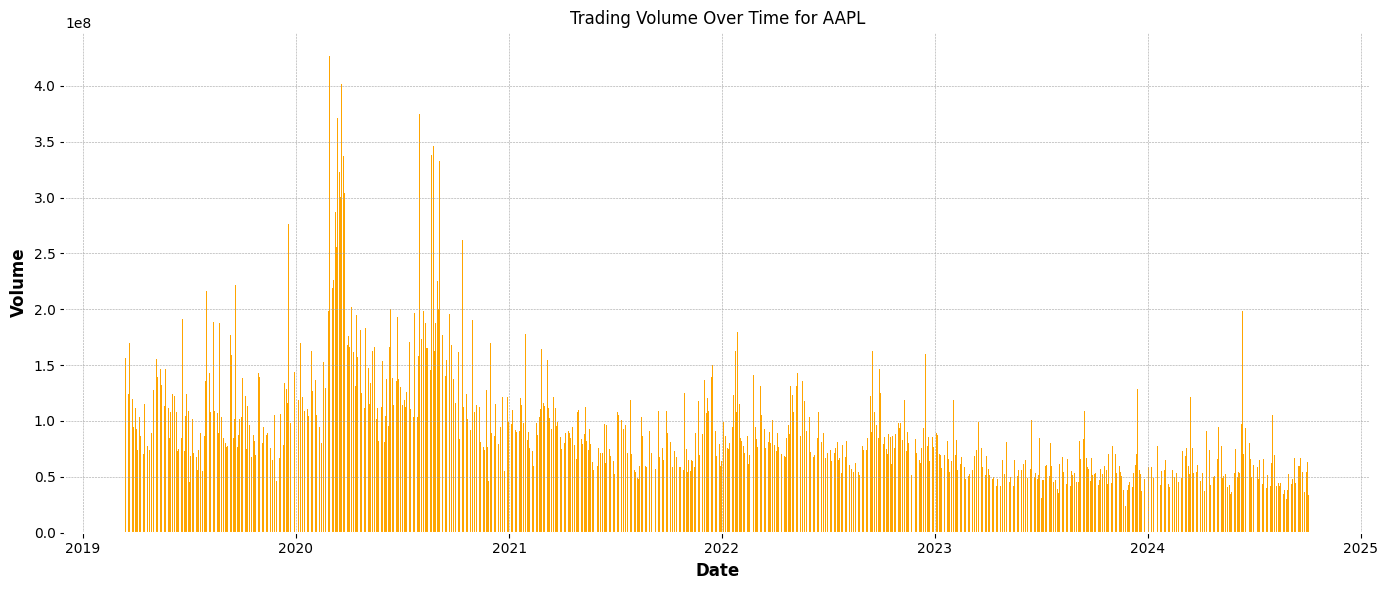

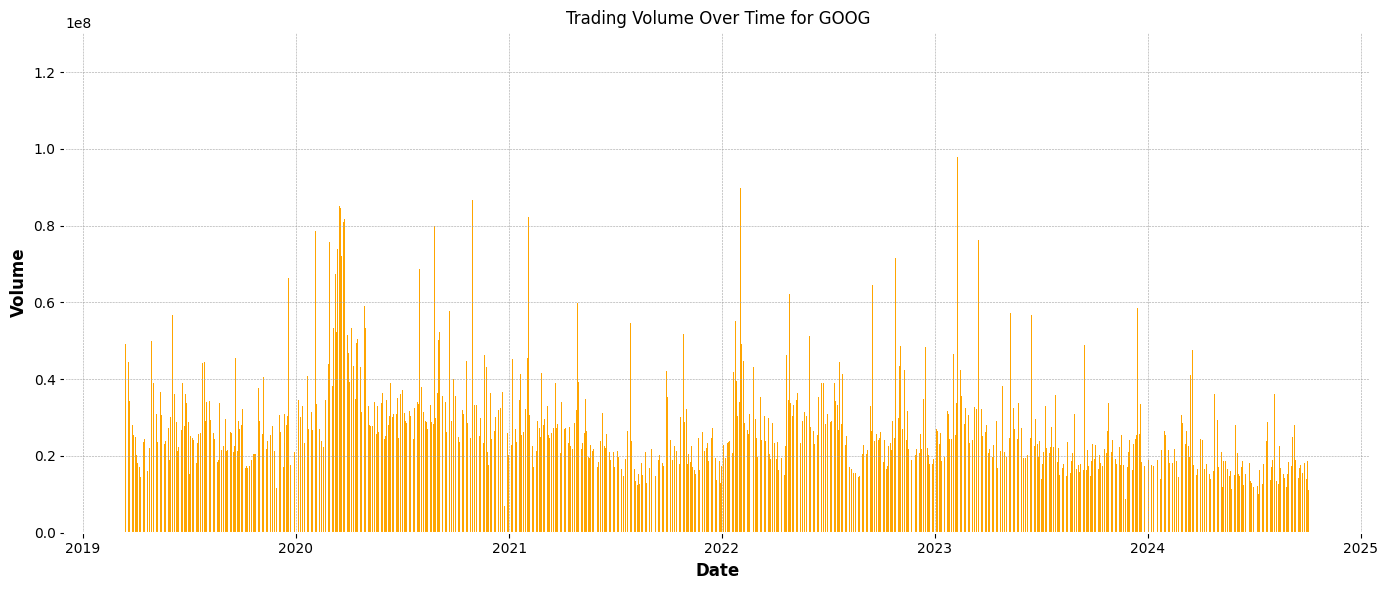

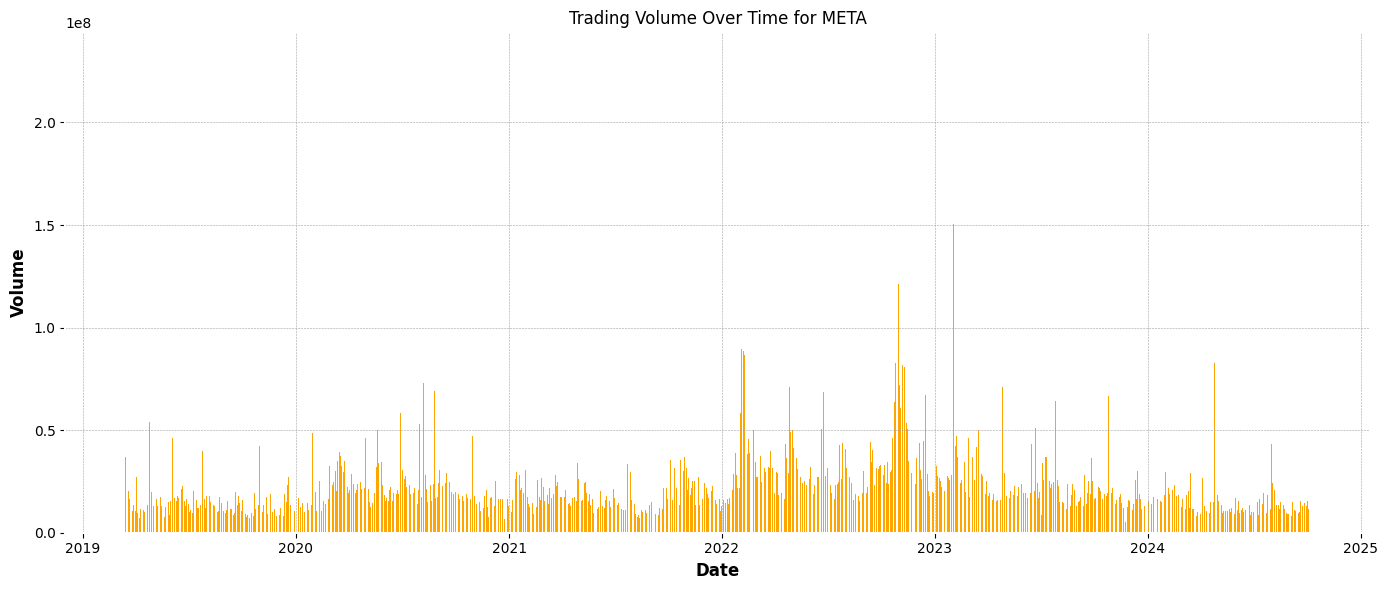

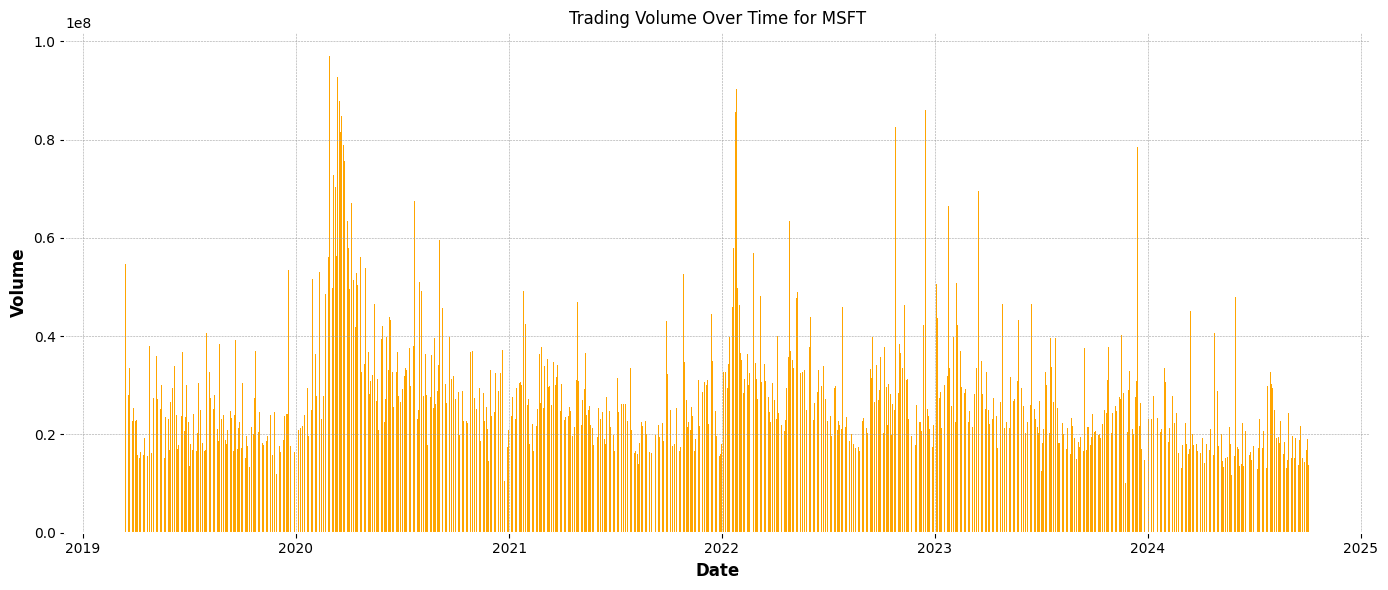

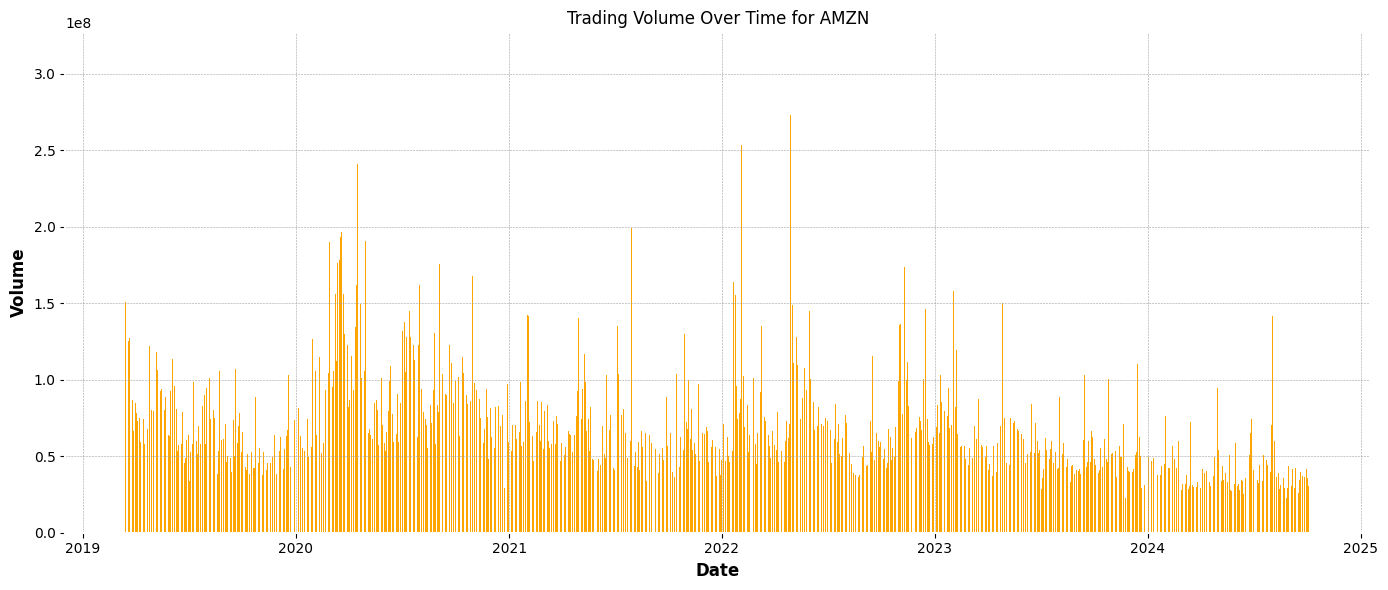

In [17]:
# Generate Volume Traded Over Time Plots for each Ticker
for ticker in tickers:
    df = ticker_data[ticker]
    plt.figure(figsize=(14, 6))
    plt.bar(df.index, df['Volume'], color='orange')
    plt.title(f'Trading Volume Over Time for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


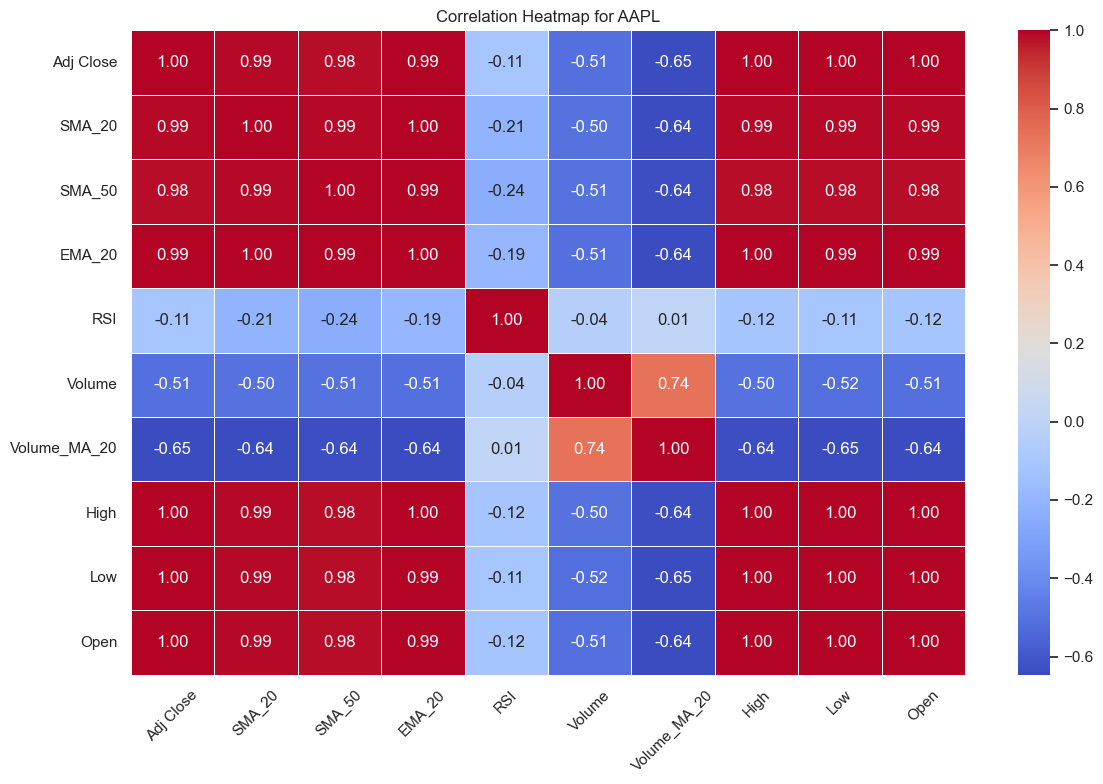

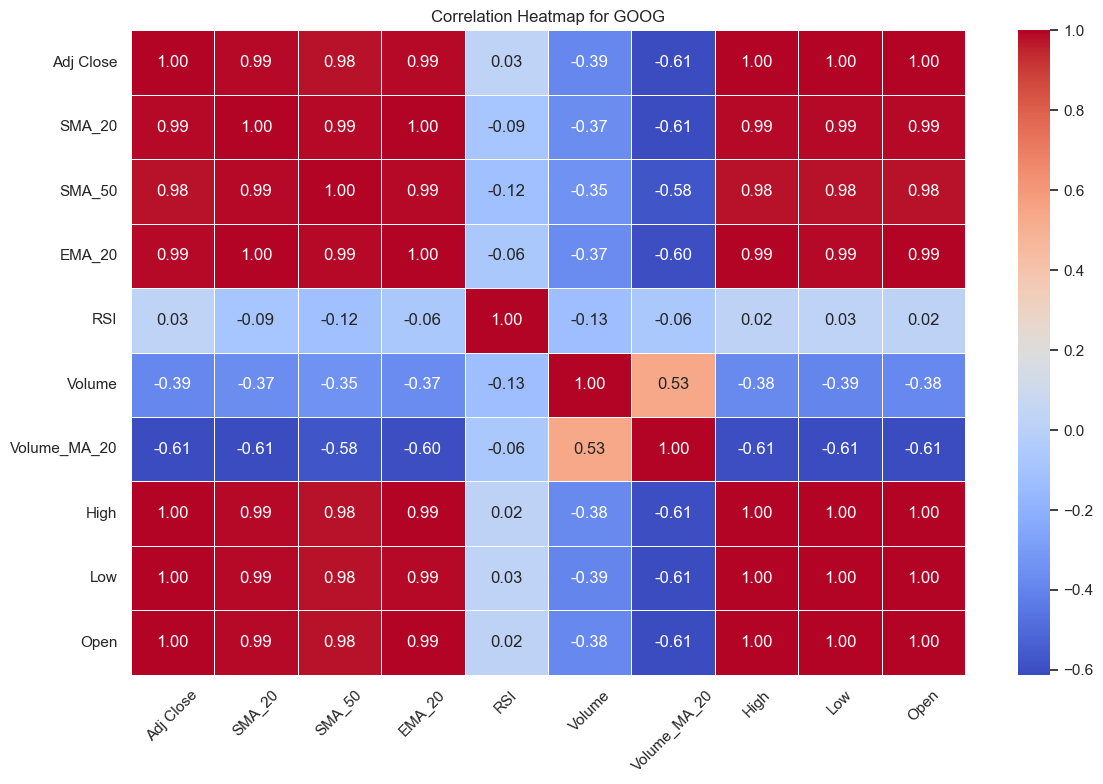

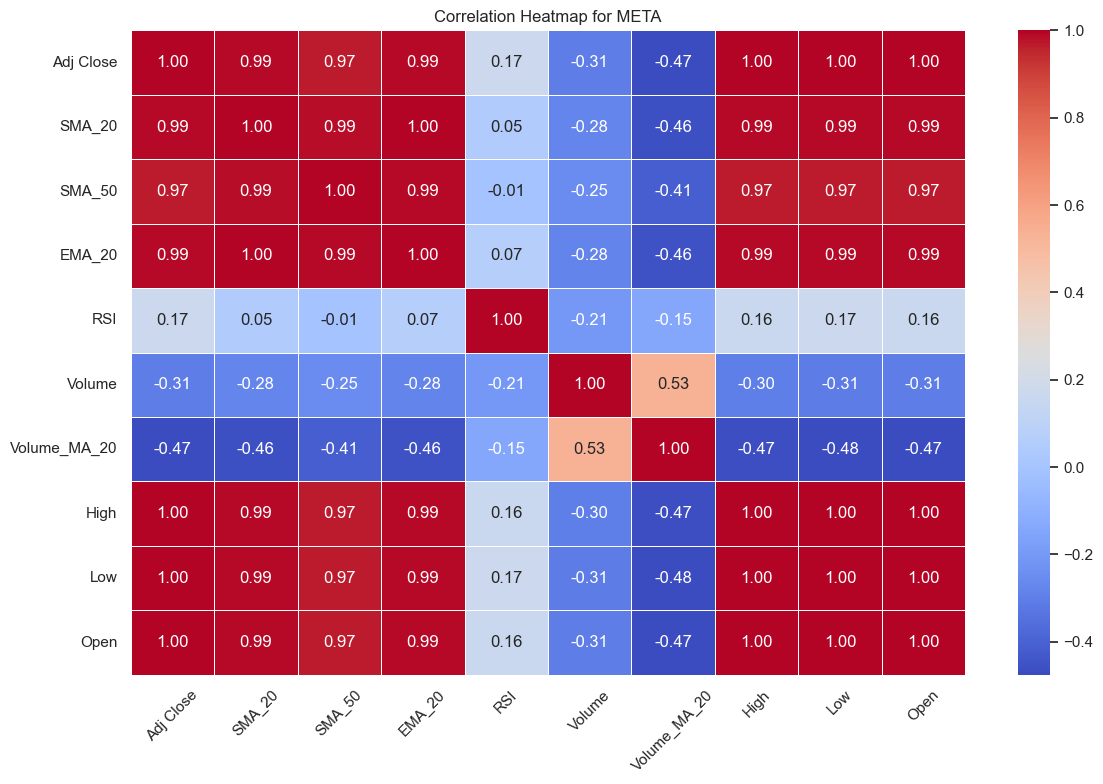

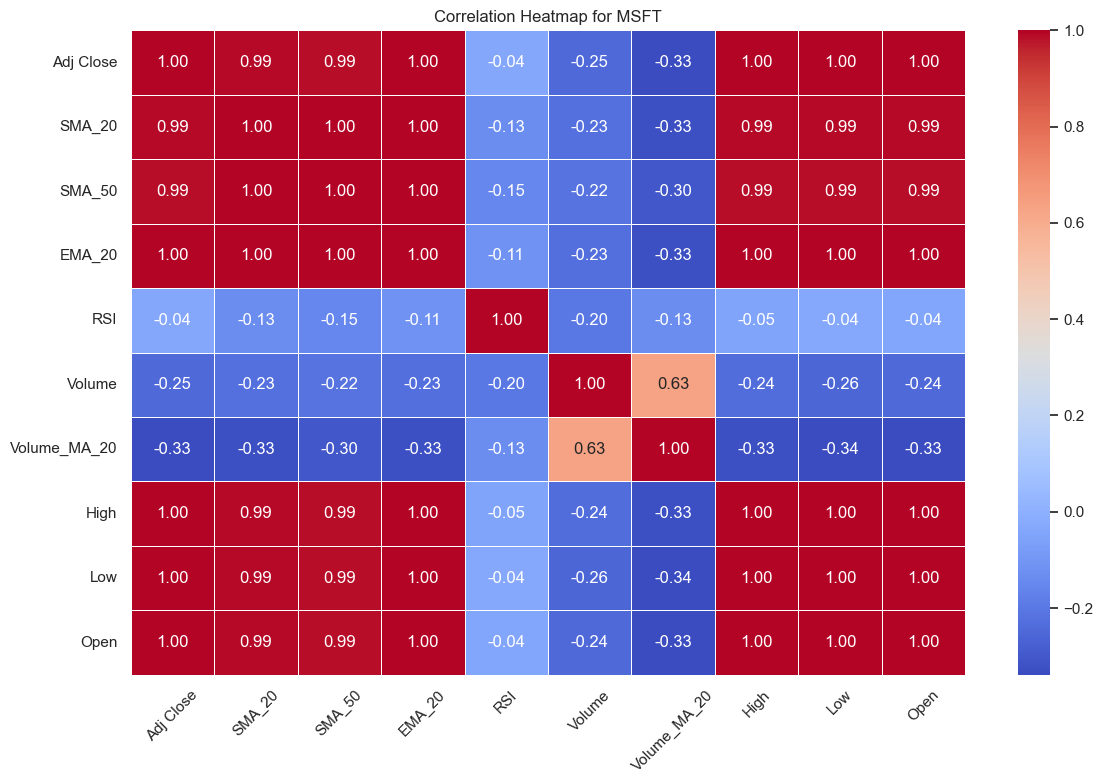

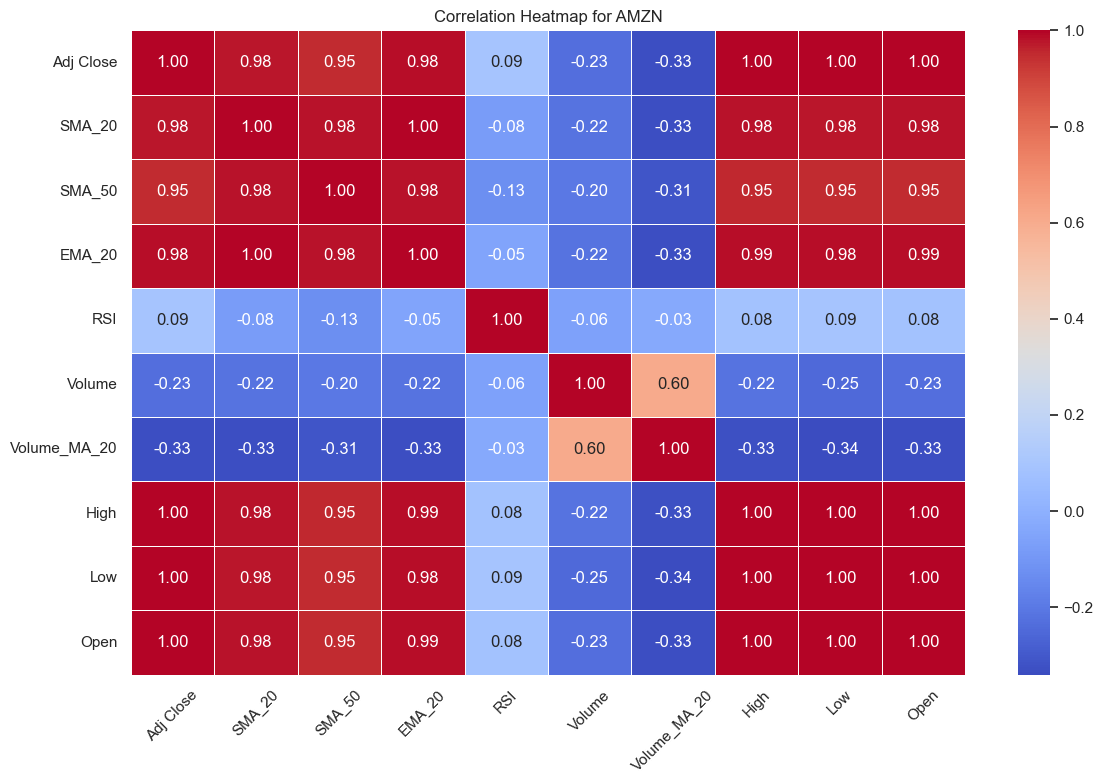

In [18]:


# Plot settings
sns.set(style='whitegrid')

# Generate Heatmaps of Correlations for each Ticker
for ticker in tickers:
    df = ticker_data[ticker]
    # Compute the correlation matrix for selected features
    features = ['Adj Close', 'SMA_20', 'SMA_50', 'EMA_20', 'RSI', 'Volume', 'Volume_MA_20', 'High', 'Low', 'Open']
    corr = df[features].corr()
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
    plt.title(f'Correlation Heatmap for {ticker}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()